## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net, Net1, Net2



In [3]:
net = Net2()
net.cuda()
print(net)

Net2(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.2)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout2d(p=0.2)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

In [4]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])

# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [5]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


D:\pythonProjects\Vision\P1_Facial_Keypoints\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [6]:
# load training data in batches
batch_size = 30

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [7]:
 for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            if batch_i !=0:
                break
            images = data['image']
            key_pts = data['keypoints']
            print(type(key_pts))

D:\pythonProjects\Vision\P1_Facial_Keypoints\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


<class 'torch.Tensor'>


## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range. 

In [8]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)



In [9]:
# load test data in batches
batch_size = 30

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [10]:
# test the model on a batch of test images
from torch.autograd import Variable


net.load_state_dict(torch.load('saved_models/keypoints_model_3_500epoch.pt'))
def net_sample_output():
    
    net.eval()
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)
        
        images = Variable(images)

        # forward pass to get net output
        #print (images)
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [11]:
def net_sample_output1():
    
    # iterate through the test dataset
    for i, sample in enumerate(train_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.cuda.FloatTensor)
        
        images = Variable(images)

        # forward pass to get net output
        #print (images)
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [28]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([30, 1, 224, 224])
torch.Size([30, 68, 2])
torch.Size([30, 68, 2])


D:\pythonProjects\Vision\P1_Facial_Keypoints\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [23]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\matplotlib\pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


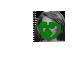

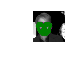

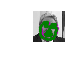

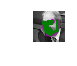

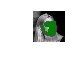

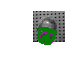

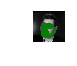

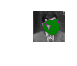

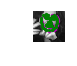

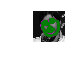

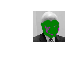

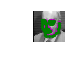

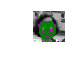

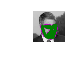

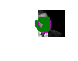

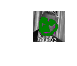

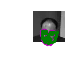

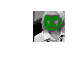

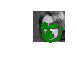

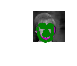

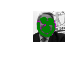

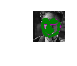

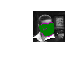

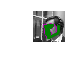

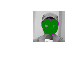

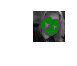

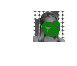

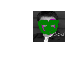

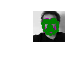

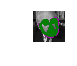

In [29]:
# visualize the output
# by default this shows a batch of 10 images

def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data.cpu()   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data.cpu()
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts, batch_size)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

In [13]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=.001)


## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

In [15]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)
            images = Variable(images)
            key_pts = Variable(key_pts)

            # forward pass to get outputs
            output_pts = net(images)
            
            #output_pts = output_pts.type(torch.FloatTensor)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            #loss = loss.type(torch.FloatTensor)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            #print (loss)
            running_loss += loss[0]
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')


In [73]:
# train your network
n_epochs = 500 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

D:\pythonProjects\Vision\P1_Facial_Keypoints\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1, Batch: 10, Avg. Loss: 0.0005432410980574787
Epoch: 1, Batch: 20, Avg. Loss: 0.0003985000366810709
Epoch: 1, Batch: 30, Avg. Loss: 0.000458037102362141
Epoch: 1, Batch: 40, Avg. Loss: 0.0003874073445331305
Epoch: 1, Batch: 50, Avg. Loss: 0.0003498231526464224
Epoch: 1, Batch: 60, Avg. Loss: 0.000982432160526514
Epoch: 1, Batch: 70, Avg. Loss: 0.00045253345160745084
Epoch: 2, Batch: 10, Avg. Loss: 0.00035835523158311844
Epoch: 2, Batch: 20, Avg. Loss: 0.0005673799896612763
Epoch: 2, Batch: 30, Avg. Loss: 0.0003454704419709742
Epoch: 2, Batch: 40, Avg. Loss: 0.0004668755573220551
Epoch: 2, Batch: 50, Avg. Loss: 0.0003539645404089242
Epoch: 2, Batch: 60, Avg. Loss: 0.00040379699203185737
Epoch: 2, Batch: 70, Avg. Loss: 0.0003048932703677565
Epoch: 3, Batch: 10, Avg. Loss: 0.00032322609331458807
Epoch: 3, Batch: 20, Avg. Loss: 0.0003438250278122723
Epoch: 3, Batch: 30, Avg. Loss: 0.0003099483728874475
Epoch: 3, Batch: 40, Avg. Loss: 0.0004604692803695798
Epoch: 3, Batch: 50, Avg. 

Epoch: 22, Batch: 40, Avg. Loss: 0.0003122694615740329
Epoch: 22, Batch: 50, Avg. Loss: 0.0003336528316140175
Epoch: 22, Batch: 60, Avg. Loss: 0.00041878115735016763
Epoch: 22, Batch: 70, Avg. Loss: 0.00029029411962255836
Epoch: 23, Batch: 10, Avg. Loss: 0.0003265253035351634
Epoch: 23, Batch: 20, Avg. Loss: 0.0003362937131896615
Epoch: 23, Batch: 30, Avg. Loss: 0.0003002654993906617
Epoch: 23, Batch: 40, Avg. Loss: 0.00037827171036042273
Epoch: 23, Batch: 50, Avg. Loss: 0.0003183915978297591
Epoch: 23, Batch: 60, Avg. Loss: 0.0003691596502903849
Epoch: 23, Batch: 70, Avg. Loss: 0.0002930199261754751
Epoch: 24, Batch: 10, Avg. Loss: 0.00039141628076322377
Epoch: 24, Batch: 20, Avg. Loss: 0.00031895790016278625
Epoch: 24, Batch: 30, Avg. Loss: 0.0002950328344013542
Epoch: 24, Batch: 40, Avg. Loss: 0.00040552709833718836
Epoch: 24, Batch: 50, Avg. Loss: 0.0002916308003477752
Epoch: 24, Batch: 60, Avg. Loss: 0.0005974469240754843
Epoch: 24, Batch: 70, Avg. Loss: 0.0004510892031248659
Epoc

Epoch: 43, Batch: 50, Avg. Loss: 0.00027078561834059656
Epoch: 43, Batch: 60, Avg. Loss: 0.0004207430756650865
Epoch: 43, Batch: 70, Avg. Loss: 0.00027023133588954806
Epoch: 44, Batch: 10, Avg. Loss: 0.00027861190028488636
Epoch: 44, Batch: 20, Avg. Loss: 0.00036096872645430267
Epoch: 44, Batch: 30, Avg. Loss: 0.0002619721635710448
Epoch: 44, Batch: 40, Avg. Loss: 0.0002971864596474916
Epoch: 44, Batch: 50, Avg. Loss: 0.0002878869418054819
Epoch: 44, Batch: 60, Avg. Loss: 0.00039309795829467475
Epoch: 44, Batch: 70, Avg. Loss: 0.0002632000541780144
Epoch: 45, Batch: 10, Avg. Loss: 0.00028062655474059284
Epoch: 45, Batch: 20, Avg. Loss: 0.00025710754562169313
Epoch: 45, Batch: 30, Avg. Loss: 0.0003638767229858786
Epoch: 45, Batch: 40, Avg. Loss: 0.0004921774961985648
Epoch: 45, Batch: 50, Avg. Loss: 0.00029915530467405915
Epoch: 45, Batch: 60, Avg. Loss: 0.0003369090845808387
Epoch: 45, Batch: 70, Avg. Loss: 0.0003310593019705266
Epoch: 46, Batch: 10, Avg. Loss: 0.0002800743095576763
Ep

Epoch: 64, Batch: 60, Avg. Loss: 0.00032431597355753183
Epoch: 64, Batch: 70, Avg. Loss: 0.0002784983953461051
Epoch: 65, Batch: 10, Avg. Loss: 0.00031212292378768325
Epoch: 65, Batch: 20, Avg. Loss: 0.0002964989689644426
Epoch: 65, Batch: 30, Avg. Loss: 0.00034732671338133514
Epoch: 65, Batch: 40, Avg. Loss: 0.00026715753483586013
Epoch: 65, Batch: 50, Avg. Loss: 0.0003193846787326038
Epoch: 65, Batch: 60, Avg. Loss: 0.00026624836027622223
Epoch: 65, Batch: 70, Avg. Loss: 0.00026601573335938156
Epoch: 66, Batch: 10, Avg. Loss: 0.000260140688624233
Epoch: 66, Batch: 20, Avg. Loss: 0.00023745850194245577
Epoch: 66, Batch: 30, Avg. Loss: 0.0002778725465759635
Epoch: 66, Batch: 40, Avg. Loss: 0.00048009026795625687
Epoch: 66, Batch: 50, Avg. Loss: 0.00030447784229181707
Epoch: 66, Batch: 60, Avg. Loss: 0.00024344328267034143
Epoch: 66, Batch: 70, Avg. Loss: 0.0002476109948474914
Epoch: 67, Batch: 10, Avg. Loss: 0.0003196842735633254
Epoch: 67, Batch: 20, Avg. Loss: 0.00025468209059908986


Epoch: 85, Batch: 70, Avg. Loss: 0.0002964689920190722
Epoch: 86, Batch: 10, Avg. Loss: 0.00022580675431527197
Epoch: 86, Batch: 20, Avg. Loss: 0.00030389276798814535
Epoch: 86, Batch: 30, Avg. Loss: 0.0002536805404815823
Epoch: 86, Batch: 40, Avg. Loss: 0.00035477615892887115
Epoch: 86, Batch: 50, Avg. Loss: 0.00021294387988746166
Epoch: 86, Batch: 60, Avg. Loss: 0.0002928301109932363
Epoch: 86, Batch: 70, Avg. Loss: 0.000271276367129758
Epoch: 87, Batch: 10, Avg. Loss: 0.0002597566053736955
Epoch: 87, Batch: 20, Avg. Loss: 0.00024855323135852814
Epoch: 87, Batch: 30, Avg. Loss: 0.0005059903487563133
Epoch: 87, Batch: 40, Avg. Loss: 0.0002605899644549936
Epoch: 87, Batch: 50, Avg. Loss: 0.00023047003196552396
Epoch: 87, Batch: 60, Avg. Loss: 0.0002938995021395385
Epoch: 87, Batch: 70, Avg. Loss: 0.0002503134310245514
Epoch: 88, Batch: 10, Avg. Loss: 0.00029232361703179777
Epoch: 88, Batch: 20, Avg. Loss: 0.0003119038592558354
Epoch: 88, Batch: 30, Avg. Loss: 0.0002541346475481987
Epoc

Epoch: 106, Batch: 70, Avg. Loss: 0.0005250131944194436
Epoch: 107, Batch: 10, Avg. Loss: 0.00025978070334531367
Epoch: 107, Batch: 20, Avg. Loss: 0.0003194902092218399
Epoch: 107, Batch: 30, Avg. Loss: 0.0002481215924490243
Epoch: 107, Batch: 40, Avg. Loss: 0.0002889349707402289
Epoch: 107, Batch: 50, Avg. Loss: 0.0002729856059886515
Epoch: 107, Batch: 60, Avg. Loss: 0.0002487409219611436
Epoch: 107, Batch: 70, Avg. Loss: 0.00021353074407670647
Epoch: 108, Batch: 10, Avg. Loss: 0.00022098360932432115
Epoch: 108, Batch: 20, Avg. Loss: 0.000292255193926394
Epoch: 108, Batch: 30, Avg. Loss: 0.00029369918047450483
Epoch: 108, Batch: 40, Avg. Loss: 0.0003362290153745562
Epoch: 108, Batch: 50, Avg. Loss: 0.000208171404665336
Epoch: 108, Batch: 60, Avg. Loss: 0.00024242329527623951
Epoch: 108, Batch: 70, Avg. Loss: 0.00023310288088396192
Epoch: 109, Batch: 10, Avg. Loss: 0.00029029176221229136
Epoch: 109, Batch: 20, Avg. Loss: 0.00022029726824257523
Epoch: 109, Batch: 30, Avg. Loss: 0.000217

Epoch: 127, Batch: 60, Avg. Loss: 0.00023896410129964352
Epoch: 127, Batch: 70, Avg. Loss: 0.00025645943242125213
Epoch: 128, Batch: 10, Avg. Loss: 0.00025112408911809325
Epoch: 128, Batch: 20, Avg. Loss: 0.00024222189676947892
Epoch: 128, Batch: 30, Avg. Loss: 0.00022029750107321888
Epoch: 128, Batch: 40, Avg. Loss: 0.00023589491320308298
Epoch: 128, Batch: 50, Avg. Loss: 0.00021941079467069358
Epoch: 128, Batch: 60, Avg. Loss: 0.0004127441206946969
Epoch: 128, Batch: 70, Avg. Loss: 0.00023709051311016083
Epoch: 129, Batch: 10, Avg. Loss: 0.0003447525086812675
Epoch: 129, Batch: 20, Avg. Loss: 0.00023352143762167543
Epoch: 129, Batch: 30, Avg. Loss: 0.000251397694228217
Epoch: 129, Batch: 40, Avg. Loss: 0.0002652232942637056
Epoch: 129, Batch: 50, Avg. Loss: 0.00029222044395282865
Epoch: 129, Batch: 60, Avg. Loss: 0.00025482341879978776
Epoch: 129, Batch: 70, Avg. Loss: 0.00029869109857827425
Epoch: 130, Batch: 10, Avg. Loss: 0.0002483446733094752
Epoch: 130, Batch: 20, Avg. Loss: 0.0

Epoch: 148, Batch: 40, Avg. Loss: 0.00023457891074940562
Epoch: 148, Batch: 50, Avg. Loss: 0.0002551941724959761
Epoch: 148, Batch: 60, Avg. Loss: 0.00024228218535427004
Epoch: 148, Batch: 70, Avg. Loss: 0.00022058434842620045
Epoch: 149, Batch: 10, Avg. Loss: 0.00024457278777845204
Epoch: 149, Batch: 20, Avg. Loss: 0.0004723884630948305
Epoch: 149, Batch: 30, Avg. Loss: 0.00022680996335111558
Epoch: 149, Batch: 40, Avg. Loss: 0.0005180452135391533
Epoch: 149, Batch: 50, Avg. Loss: 0.0002977785770781338
Epoch: 149, Batch: 60, Avg. Loss: 0.0002911576011683792
Epoch: 149, Batch: 70, Avg. Loss: 0.00022208782320376486
Epoch: 150, Batch: 10, Avg. Loss: 0.00023987122403923422
Epoch: 150, Batch: 20, Avg. Loss: 0.0006383778527379036
Epoch: 150, Batch: 30, Avg. Loss: 0.0002565121103543788
Epoch: 150, Batch: 40, Avg. Loss: 0.00021144661877769977
Epoch: 150, Batch: 50, Avg. Loss: 0.00022128771524876356
Epoch: 150, Batch: 60, Avg. Loss: 0.00022488630202133209
Epoch: 150, Batch: 70, Avg. Loss: 0.00

Epoch: 169, Batch: 20, Avg. Loss: 0.00020749513350892812
Epoch: 169, Batch: 30, Avg. Loss: 0.00026753783458843827
Epoch: 169, Batch: 40, Avg. Loss: 0.00028854445554316044
Epoch: 169, Batch: 50, Avg. Loss: 0.00020875032350886613
Epoch: 169, Batch: 60, Avg. Loss: 0.00023920573585201055
Epoch: 169, Batch: 70, Avg. Loss: 0.00020536230294965208
Epoch: 170, Batch: 10, Avg. Loss: 0.00022732201614417136
Epoch: 170, Batch: 20, Avg. Loss: 0.0003291216562502086
Epoch: 170, Batch: 30, Avg. Loss: 0.000233715953072533
Epoch: 170, Batch: 40, Avg. Loss: 0.00023452648019883782
Epoch: 170, Batch: 50, Avg. Loss: 0.00024076236877590418
Epoch: 170, Batch: 60, Avg. Loss: 0.00021831263438798487
Epoch: 170, Batch: 70, Avg. Loss: 0.00022448186064139009
Epoch: 171, Batch: 10, Avg. Loss: 0.0002355366450501606
Epoch: 171, Batch: 20, Avg. Loss: 0.00023818040790501982
Epoch: 171, Batch: 30, Avg. Loss: 0.00022197849466465414
Epoch: 171, Batch: 40, Avg. Loss: 0.00022991128207650036
Epoch: 171, Batch: 50, Avg. Loss: 0

Epoch: 189, Batch: 70, Avg. Loss: 0.00020148213661741465
Epoch: 190, Batch: 10, Avg. Loss: 0.00021958447177894413
Epoch: 190, Batch: 20, Avg. Loss: 0.00022410582459997386
Epoch: 190, Batch: 30, Avg. Loss: 0.00023811167920939624
Epoch: 190, Batch: 40, Avg. Loss: 0.00021000606648158282
Epoch: 190, Batch: 50, Avg. Loss: 0.00025951783754862845
Epoch: 190, Batch: 60, Avg. Loss: 0.00023099873214960098
Epoch: 190, Batch: 70, Avg. Loss: 0.00021991886023897678
Epoch: 191, Batch: 10, Avg. Loss: 0.00023605371825397015
Epoch: 191, Batch: 20, Avg. Loss: 0.00037079903995618224
Epoch: 191, Batch: 30, Avg. Loss: 0.0002388148132013157
Epoch: 191, Batch: 40, Avg. Loss: 0.00022094030282460153
Epoch: 191, Batch: 50, Avg. Loss: 0.00022313011868391186
Epoch: 191, Batch: 60, Avg. Loss: 0.00024587655207142234
Epoch: 191, Batch: 70, Avg. Loss: 0.0002128196501871571
Epoch: 192, Batch: 10, Avg. Loss: 0.00021247222321107984
Epoch: 192, Batch: 20, Avg. Loss: 0.00022450527467299253
Epoch: 192, Batch: 30, Avg. Loss:

Epoch: 210, Batch: 50, Avg. Loss: 0.0002659537422005087
Epoch: 210, Batch: 60, Avg. Loss: 0.00020532878988888115
Epoch: 210, Batch: 70, Avg. Loss: 0.00024840206606313586
Epoch: 211, Batch: 10, Avg. Loss: 0.0002374852920183912
Epoch: 211, Batch: 20, Avg. Loss: 0.00019669010362122208
Epoch: 211, Batch: 30, Avg. Loss: 0.0002257495652884245
Epoch: 211, Batch: 40, Avg. Loss: 0.00020976073574274778
Epoch: 211, Batch: 50, Avg. Loss: 0.00022293560323305428
Epoch: 211, Batch: 60, Avg. Loss: 0.00022263576101977378
Epoch: 211, Batch: 70, Avg. Loss: 0.0002866304712370038
Epoch: 212, Batch: 10, Avg. Loss: 0.0002492224157322198
Epoch: 212, Batch: 20, Avg. Loss: 0.00023146564490161836
Epoch: 212, Batch: 30, Avg. Loss: 0.0002191417443100363
Epoch: 212, Batch: 40, Avg. Loss: 0.00023020400840323418
Epoch: 212, Batch: 50, Avg. Loss: 0.00022356388217303902
Epoch: 212, Batch: 60, Avg. Loss: 0.00021480739815160632
Epoch: 212, Batch: 70, Avg. Loss: 0.0001958165958058089
Epoch: 213, Batch: 10, Avg. Loss: 0.00

Epoch: 231, Batch: 30, Avg. Loss: 0.0002129072672687471
Epoch: 231, Batch: 40, Avg. Loss: 0.00019993999740108848
Epoch: 231, Batch: 50, Avg. Loss: 0.00019132344459649175
Epoch: 231, Batch: 60, Avg. Loss: 0.00020089097961317748
Epoch: 231, Batch: 70, Avg. Loss: 0.00021793106861878186
Epoch: 232, Batch: 10, Avg. Loss: 0.0001822364574763924
Epoch: 232, Batch: 20, Avg. Loss: 0.00021523488976527005
Epoch: 232, Batch: 30, Avg. Loss: 0.0002094495139317587
Epoch: 232, Batch: 40, Avg. Loss: 0.00020393641898408532
Epoch: 232, Batch: 50, Avg. Loss: 0.0002190105151385069
Epoch: 232, Batch: 60, Avg. Loss: 0.00022121830261312425
Epoch: 232, Batch: 70, Avg. Loss: 0.00020254844275768846
Epoch: 233, Batch: 10, Avg. Loss: 0.00022189333685673773
Epoch: 233, Batch: 20, Avg. Loss: 0.000280330132227391
Epoch: 233, Batch: 30, Avg. Loss: 0.00019872472330462188
Epoch: 233, Batch: 40, Avg. Loss: 0.00023040585801936686
Epoch: 233, Batch: 50, Avg. Loss: 0.00021539084264077246
Epoch: 233, Batch: 60, Avg. Loss: 0.0

Epoch: 252, Batch: 10, Avg. Loss: 0.00021016332902945578
Epoch: 252, Batch: 20, Avg. Loss: 0.00019394044647924602
Epoch: 252, Batch: 30, Avg. Loss: 0.00019639953097794205
Epoch: 252, Batch: 40, Avg. Loss: 0.00020571897039189935
Epoch: 252, Batch: 50, Avg. Loss: 0.00021742012177128345
Epoch: 252, Batch: 60, Avg. Loss: 0.00020504085114225745
Epoch: 252, Batch: 70, Avg. Loss: 0.0002250909456051886
Epoch: 253, Batch: 10, Avg. Loss: 0.00019490631530061364
Epoch: 253, Batch: 20, Avg. Loss: 0.00023118093668017536
Epoch: 253, Batch: 30, Avg. Loss: 0.0002140423166565597
Epoch: 253, Batch: 40, Avg. Loss: 0.0001837824675021693
Epoch: 253, Batch: 50, Avg. Loss: 0.00018102351168636233
Epoch: 253, Batch: 60, Avg. Loss: 0.0002371410228079185
Epoch: 253, Batch: 70, Avg. Loss: 0.0002490231127012521
Epoch: 254, Batch: 10, Avg. Loss: 0.00020691707322839648
Epoch: 254, Batch: 20, Avg. Loss: 0.00020537895034067333
Epoch: 254, Batch: 30, Avg. Loss: 0.00019425415666773915
Epoch: 254, Batch: 40, Avg. Loss: 0.

Epoch: 272, Batch: 60, Avg. Loss: 0.000209840465686284
Epoch: 272, Batch: 70, Avg. Loss: 0.00021752978500444442
Epoch: 273, Batch: 10, Avg. Loss: 0.00020637236593756825
Epoch: 273, Batch: 20, Avg. Loss: 0.00023125921143218875
Epoch: 273, Batch: 30, Avg. Loss: 0.00021779179223813117
Epoch: 273, Batch: 40, Avg. Loss: 0.00018633276340551674
Epoch: 273, Batch: 50, Avg. Loss: 0.00022110088320914656
Epoch: 273, Batch: 60, Avg. Loss: 0.00024298703647218645
Epoch: 273, Batch: 70, Avg. Loss: 0.00021606255904771388
Epoch: 274, Batch: 10, Avg. Loss: 0.0002419503143755719
Epoch: 274, Batch: 20, Avg. Loss: 0.00038734081317670643
Epoch: 274, Batch: 30, Avg. Loss: 0.00023424388200510293
Epoch: 274, Batch: 40, Avg. Loss: 0.0002031761541729793
Epoch: 274, Batch: 50, Avg. Loss: 0.00019248684111516923
Epoch: 274, Batch: 60, Avg. Loss: 0.0001870802661869675
Epoch: 274, Batch: 70, Avg. Loss: 0.00020451951422728598
Epoch: 275, Batch: 10, Avg. Loss: 0.0002217043365817517
Epoch: 275, Batch: 20, Avg. Loss: 0.0

Epoch: 293, Batch: 40, Avg. Loss: 0.00020926209981553257
Epoch: 293, Batch: 50, Avg. Loss: 0.00019344074826221913
Epoch: 293, Batch: 60, Avg. Loss: 0.00024550381931476295
Epoch: 293, Batch: 70, Avg. Loss: 0.0001964203838724643
Epoch: 294, Batch: 10, Avg. Loss: 0.00019147164130117744
Epoch: 294, Batch: 20, Avg. Loss: 0.0001825964864110574
Epoch: 294, Batch: 30, Avg. Loss: 0.00018313041073270142
Epoch: 294, Batch: 40, Avg. Loss: 0.00022032704146113247
Epoch: 294, Batch: 50, Avg. Loss: 0.0002996295806951821
Epoch: 294, Batch: 60, Avg. Loss: 0.00020324348588474095
Epoch: 294, Batch: 70, Avg. Loss: 0.00020184686582069844
Epoch: 295, Batch: 10, Avg. Loss: 0.00020465350826270878
Epoch: 295, Batch: 20, Avg. Loss: 0.00023437778872903436
Epoch: 295, Batch: 30, Avg. Loss: 0.0002158074639737606
Epoch: 295, Batch: 40, Avg. Loss: 0.00017388163541909307
Epoch: 295, Batch: 50, Avg. Loss: 0.00020433076133485883
Epoch: 295, Batch: 60, Avg. Loss: 0.0001885509118437767
Epoch: 295, Batch: 70, Avg. Loss: 0.

Epoch: 314, Batch: 20, Avg. Loss: 0.0002063243300653994
Epoch: 314, Batch: 30, Avg. Loss: 0.00021508529607672244
Epoch: 314, Batch: 40, Avg. Loss: 0.00020801475329790264
Epoch: 314, Batch: 50, Avg. Loss: 0.00018841007840819657
Epoch: 314, Batch: 60, Avg. Loss: 0.00025047719827853143
Epoch: 314, Batch: 70, Avg. Loss: 0.0002006588620133698
Epoch: 315, Batch: 10, Avg. Loss: 0.00020917761139571667
Epoch: 315, Batch: 20, Avg. Loss: 0.0002016659709624946
Epoch: 315, Batch: 30, Avg. Loss: 0.00018859506235457957
Epoch: 315, Batch: 40, Avg. Loss: 0.00018409689073450863
Epoch: 315, Batch: 50, Avg. Loss: 0.00022387760691344738
Epoch: 315, Batch: 60, Avg. Loss: 0.0001877108443295583
Epoch: 315, Batch: 70, Avg. Loss: 0.00021066152839921415
Epoch: 316, Batch: 10, Avg. Loss: 0.0002304557419847697
Epoch: 316, Batch: 20, Avg. Loss: 0.00019760668510571122
Epoch: 316, Batch: 30, Avg. Loss: 0.00023078934464138
Epoch: 316, Batch: 40, Avg. Loss: 0.00019259643158875406
Epoch: 316, Batch: 50, Avg. Loss: 0.000

Epoch: 334, Batch: 70, Avg. Loss: 0.00020348852558527142
Epoch: 335, Batch: 10, Avg. Loss: 0.00020065977878402919
Epoch: 335, Batch: 20, Avg. Loss: 0.00022690166952088475
Epoch: 335, Batch: 30, Avg. Loss: 0.00020580737327691168
Epoch: 335, Batch: 40, Avg. Loss: 0.00018745596753433347
Epoch: 335, Batch: 50, Avg. Loss: 0.0002542283327784389
Epoch: 335, Batch: 60, Avg. Loss: 0.00019735803653020412
Epoch: 335, Batch: 70, Avg. Loss: 0.0001856265007518232
Epoch: 336, Batch: 10, Avg. Loss: 0.00018694234313443303
Epoch: 336, Batch: 20, Avg. Loss: 0.00018752168398350477
Epoch: 336, Batch: 30, Avg. Loss: 0.00018242515216115862
Epoch: 336, Batch: 40, Avg. Loss: 0.00016246781160589308
Epoch: 336, Batch: 50, Avg. Loss: 0.00021836684027221054
Epoch: 336, Batch: 60, Avg. Loss: 0.00020983970898669213
Epoch: 336, Batch: 70, Avg. Loss: 0.00018539738084655255
Epoch: 337, Batch: 10, Avg. Loss: 0.00029819057090207934
Epoch: 337, Batch: 20, Avg. Loss: 0.0002010299649555236
Epoch: 337, Batch: 30, Avg. Loss: 

Epoch: 355, Batch: 50, Avg. Loss: 0.00021341849060263485
Epoch: 355, Batch: 60, Avg. Loss: 0.00020264206978026778
Epoch: 355, Batch: 70, Avg. Loss: 0.00018600655312184244
Epoch: 356, Batch: 10, Avg. Loss: 0.00020737232989631593
Epoch: 356, Batch: 20, Avg. Loss: 0.00020286327344365418
Epoch: 356, Batch: 30, Avg. Loss: 0.00018757731595542282
Epoch: 356, Batch: 40, Avg. Loss: 0.0001734444813337177
Epoch: 356, Batch: 50, Avg. Loss: 0.00020641843730118126
Epoch: 356, Batch: 60, Avg. Loss: 0.00019199014059267938
Epoch: 356, Batch: 70, Avg. Loss: 0.000291538133751601
Epoch: 357, Batch: 10, Avg. Loss: 0.00021628971444442868
Epoch: 357, Batch: 20, Avg. Loss: 0.00019526465621311218
Epoch: 357, Batch: 30, Avg. Loss: 0.00021366868168115616
Epoch: 357, Batch: 40, Avg. Loss: 0.0002590202202554792
Epoch: 357, Batch: 50, Avg. Loss: 0.00022732815705239773
Epoch: 357, Batch: 60, Avg. Loss: 0.0002012707118410617
Epoch: 357, Batch: 70, Avg. Loss: 0.0001912971056299284
Epoch: 358, Batch: 10, Avg. Loss: 0.0

Epoch: 376, Batch: 30, Avg. Loss: 0.00019091305148322135
Epoch: 376, Batch: 40, Avg. Loss: 0.00019562240049708635
Epoch: 376, Batch: 50, Avg. Loss: 0.0001901684154290706
Epoch: 376, Batch: 60, Avg. Loss: 0.0002098141994792968
Epoch: 376, Batch: 70, Avg. Loss: 0.0001852403802331537
Epoch: 377, Batch: 10, Avg. Loss: 0.0001844833022914827
Epoch: 377, Batch: 20, Avg. Loss: 0.0001719331630738452
Epoch: 377, Batch: 30, Avg. Loss: 0.000217463806620799
Epoch: 377, Batch: 40, Avg. Loss: 0.00020031257008668035
Epoch: 377, Batch: 50, Avg. Loss: 0.0001984180707950145
Epoch: 377, Batch: 60, Avg. Loss: 0.00019944294763263315
Epoch: 377, Batch: 70, Avg. Loss: 0.0002078408288070932
Epoch: 378, Batch: 10, Avg. Loss: 0.00020052304898854345
Epoch: 378, Batch: 20, Avg. Loss: 0.0002128069318132475
Epoch: 378, Batch: 30, Avg. Loss: 0.00019435079593677074
Epoch: 378, Batch: 40, Avg. Loss: 0.0001922532683238387
Epoch: 378, Batch: 50, Avg. Loss: 0.00023476225032936782
Epoch: 378, Batch: 60, Avg. Loss: 0.000186

Epoch: 397, Batch: 10, Avg. Loss: 0.00019645779684651643
Epoch: 397, Batch: 20, Avg. Loss: 0.00017836818005889654
Epoch: 397, Batch: 30, Avg. Loss: 0.000198678724700585
Epoch: 397, Batch: 40, Avg. Loss: 0.00016322020383086056
Epoch: 397, Batch: 50, Avg. Loss: 0.00016828019579406828
Epoch: 397, Batch: 60, Avg. Loss: 0.0001896885660244152
Epoch: 397, Batch: 70, Avg. Loss: 0.00019770472135860473
Epoch: 398, Batch: 10, Avg. Loss: 0.00018255817121826112
Epoch: 398, Batch: 20, Avg. Loss: 0.00020924107229802758
Epoch: 398, Batch: 30, Avg. Loss: 0.00019108245032839477
Epoch: 398, Batch: 40, Avg. Loss: 0.00019918731413781643
Epoch: 398, Batch: 50, Avg. Loss: 0.00022454807185567915
Epoch: 398, Batch: 60, Avg. Loss: 0.00018002474098466337
Epoch: 398, Batch: 70, Avg. Loss: 0.00031441583996638656
Epoch: 399, Batch: 10, Avg. Loss: 0.00017808644042816013
Epoch: 399, Batch: 20, Avg. Loss: 0.00021410814952105284
Epoch: 399, Batch: 30, Avg. Loss: 0.0001915461616590619
Epoch: 399, Batch: 40, Avg. Loss: 0

Epoch: 417, Batch: 60, Avg. Loss: 0.00017775454034563154
Epoch: 417, Batch: 70, Avg. Loss: 0.00015532440738752484
Epoch: 418, Batch: 10, Avg. Loss: 0.00017583509907126427
Epoch: 418, Batch: 20, Avg. Loss: 0.00016598522779531777
Epoch: 418, Batch: 30, Avg. Loss: 0.0001905718381749466
Epoch: 418, Batch: 40, Avg. Loss: 0.00018464142340235412
Epoch: 418, Batch: 50, Avg. Loss: 0.00017097605450544506
Epoch: 418, Batch: 60, Avg. Loss: 0.00020557934476528317
Epoch: 418, Batch: 70, Avg. Loss: 0.00019272000645287335
Epoch: 419, Batch: 10, Avg. Loss: 0.00017271508113481104
Epoch: 419, Batch: 20, Avg. Loss: 0.00017572412616573274
Epoch: 419, Batch: 30, Avg. Loss: 0.0001615725486772135
Epoch: 419, Batch: 40, Avg. Loss: 0.00018398220709059387
Epoch: 419, Batch: 50, Avg. Loss: 0.00019347897614352405
Epoch: 419, Batch: 60, Avg. Loss: 0.0001792242837836966
Epoch: 419, Batch: 70, Avg. Loss: 0.00017976967501454055
Epoch: 420, Batch: 10, Avg. Loss: 0.00021574915444944054
Epoch: 420, Batch: 20, Avg. Loss: 

Epoch: 438, Batch: 40, Avg. Loss: 0.00021208373073022813
Epoch: 438, Batch: 50, Avg. Loss: 0.0001705137110548094
Epoch: 438, Batch: 60, Avg. Loss: 0.00016592256724834442
Epoch: 438, Batch: 70, Avg. Loss: 0.00019688122847583145
Epoch: 439, Batch: 10, Avg. Loss: 0.00019267515745013952
Epoch: 439, Batch: 20, Avg. Loss: 0.00019520621572155505
Epoch: 439, Batch: 30, Avg. Loss: 0.00018651061691343784
Epoch: 439, Batch: 40, Avg. Loss: 0.00016609868907835335
Epoch: 439, Batch: 50, Avg. Loss: 0.00018091606034431607
Epoch: 439, Batch: 60, Avg. Loss: 0.00019678464741446078
Epoch: 439, Batch: 70, Avg. Loss: 0.0001910105493152514
Epoch: 440, Batch: 10, Avg. Loss: 0.00016426261572632939
Epoch: 440, Batch: 20, Avg. Loss: 0.00017103094432968646
Epoch: 440, Batch: 30, Avg. Loss: 0.00018240827193949372
Epoch: 440, Batch: 40, Avg. Loss: 0.00018338429799769074
Epoch: 440, Batch: 50, Avg. Loss: 0.00018872560758609325
Epoch: 440, Batch: 60, Avg. Loss: 0.0001849262771429494
Epoch: 440, Batch: 70, Avg. Loss: 

Epoch: 459, Batch: 20, Avg. Loss: 0.00023401145881507546
Epoch: 459, Batch: 30, Avg. Loss: 0.0001627976744202897
Epoch: 459, Batch: 40, Avg. Loss: 0.0001928429410327226
Epoch: 459, Batch: 50, Avg. Loss: 0.00015973253175616264
Epoch: 459, Batch: 60, Avg. Loss: 0.0002951033238787204
Epoch: 459, Batch: 70, Avg. Loss: 0.0001913275191327557
Epoch: 460, Batch: 10, Avg. Loss: 0.00021959710284136236
Epoch: 460, Batch: 20, Avg. Loss: 0.00017081041005440056
Epoch: 460, Batch: 30, Avg. Loss: 0.0001848487154347822
Epoch: 460, Batch: 40, Avg. Loss: 0.00017636797565501183
Epoch: 460, Batch: 50, Avg. Loss: 0.00015411461936309934
Epoch: 460, Batch: 60, Avg. Loss: 0.00016333266103174537
Epoch: 460, Batch: 70, Avg. Loss: 0.00018447564798407257
Epoch: 461, Batch: 10, Avg. Loss: 0.00019252594211138785
Epoch: 461, Batch: 20, Avg. Loss: 0.00016901627532206476
Epoch: 461, Batch: 30, Avg. Loss: 0.0001779417652869597
Epoch: 461, Batch: 40, Avg. Loss: 0.0001655653031775728
Epoch: 461, Batch: 50, Avg. Loss: 0.00

Epoch: 479, Batch: 70, Avg. Loss: 0.00016665142902638763
Epoch: 480, Batch: 10, Avg. Loss: 0.00015843236178625375
Epoch: 480, Batch: 20, Avg. Loss: 0.00018132012337446213
Epoch: 480, Batch: 30, Avg. Loss: 0.00016126746777445078
Epoch: 480, Batch: 40, Avg. Loss: 0.00018288331921212375
Epoch: 480, Batch: 50, Avg. Loss: 0.000172931540873833
Epoch: 480, Batch: 60, Avg. Loss: 0.00019365365733392537
Epoch: 480, Batch: 70, Avg. Loss: 0.00018330503371544182
Epoch: 481, Batch: 10, Avg. Loss: 0.0001713241945253685
Epoch: 481, Batch: 20, Avg. Loss: 0.00017316032608505338
Epoch: 481, Batch: 30, Avg. Loss: 0.00016602256800979376
Epoch: 481, Batch: 40, Avg. Loss: 0.00017920702521223575
Epoch: 481, Batch: 50, Avg. Loss: 0.00016597674402873963
Epoch: 481, Batch: 60, Avg. Loss: 0.00020429425057955086
Epoch: 481, Batch: 70, Avg. Loss: 0.00025172234745696187
Epoch: 482, Batch: 10, Avg. Loss: 0.0001878968032542616
Epoch: 482, Batch: 20, Avg. Loss: 0.00017842260422185063
Epoch: 482, Batch: 30, Avg. Loss: 0

Epoch: 500, Batch: 50, Avg. Loss: 0.00018248542619403452
Epoch: 500, Batch: 60, Avg. Loss: 0.00017930881585925817
Epoch: 500, Batch: 70, Avg. Loss: 0.00017575439414940774
Finished Training


In [ ]:
#train alternative network
import torch.optim as optim
net = Net1()
net.cuda()
print(net)


In [24]:


criterion = nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=.001)


In [20]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)
            images = Variable(images)
            key_pts = Variable(key_pts)

            # forward pass to get outputs
            output_pts = net(images)
            
            #output_pts = output_pts.type(torch.FloatTensor)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            #loss = loss.type(torch.FloatTensor)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            #print (loss)
            running_loss += loss[0]
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0
        if (epoch == 500):
            
            optimizer = torch.optim.Adam(net.parameters(), lr=.0001)

    print('Finished Training')

In [25]:
n_epochs = 500 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

D:\pythonProjects\Vision\P1_Facial_Keypoints\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:46: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1, Batch: 10, Avg. Loss: 0.000657908502034843
Epoch: 1, Batch: 20, Avg. Loss: 0.0005307273240759969
Epoch: 1, Batch: 30, Avg. Loss: 0.0006523709744215012
Epoch: 1, Batch: 40, Avg. Loss: 0.0006007079500705004
Epoch: 1, Batch: 50, Avg. Loss: 0.0005780939827673137
Epoch: 1, Batch: 60, Avg. Loss: 0.0006341675762087107
Epoch: 1, Batch: 70, Avg. Loss: 0.0006633690791204572
Epoch: 2, Batch: 10, Avg. Loss: 0.000991463428363204
Epoch: 2, Batch: 20, Avg. Loss: 0.000988520449027419
Epoch: 2, Batch: 30, Avg. Loss: 0.0006920802989043295
Epoch: 2, Batch: 40, Avg. Loss: 0.0005548686604015529
Epoch: 2, Batch: 50, Avg. Loss: 0.000489374331664294
Epoch: 2, Batch: 60, Avg. Loss: 0.000680779165122658
Epoch: 2, Batch: 70, Avg. Loss: 0.0005621103919111192
Epoch: 3, Batch: 10, Avg. Loss: 0.0005703856004402041
Epoch: 3, Batch: 20, Avg. Loss: 0.0005586121696978807
Epoch: 3, Batch: 30, Avg. Loss: 0.0005232881521806121
Epoch: 3, Batch: 40, Avg. Loss: 0.0005289976252242923
Epoch: 3, Batch: 50, Avg. Loss: 0

Epoch: 22, Batch: 40, Avg. Loss: 0.0005464209243655205
Epoch: 22, Batch: 50, Avg. Loss: 0.0003885593614540994
Epoch: 22, Batch: 60, Avg. Loss: 0.00037046201759949327
Epoch: 22, Batch: 70, Avg. Loss: 0.0003792202624026686
Epoch: 23, Batch: 10, Avg. Loss: 0.0003830440400633961
Epoch: 23, Batch: 20, Avg. Loss: 0.00038365903310477734
Epoch: 23, Batch: 30, Avg. Loss: 0.00041732005774974823
Epoch: 23, Batch: 40, Avg. Loss: 0.00036146314232610166
Epoch: 23, Batch: 50, Avg. Loss: 0.00042635545833036304
Epoch: 23, Batch: 60, Avg. Loss: 0.0004937401972711086
Epoch: 23, Batch: 70, Avg. Loss: 0.0003695926279760897
Epoch: 24, Batch: 10, Avg. Loss: 0.0003996554878540337
Epoch: 24, Batch: 20, Avg. Loss: 0.00038274095277301967
Epoch: 24, Batch: 30, Avg. Loss: 0.0003327897284179926
Epoch: 24, Batch: 40, Avg. Loss: 0.00048289186088368297
Epoch: 24, Batch: 50, Avg. Loss: 0.0004004694055765867
Epoch: 24, Batch: 60, Avg. Loss: 0.00044815707951784134
Epoch: 24, Batch: 70, Avg. Loss: 0.00037010866799391806
E

Epoch: 43, Batch: 60, Avg. Loss: 0.0003667098644655198
Epoch: 43, Batch: 70, Avg. Loss: 0.0003073684056289494
Epoch: 44, Batch: 10, Avg. Loss: 0.00041021814104169607
Epoch: 44, Batch: 20, Avg. Loss: 0.00033577566500753164
Epoch: 44, Batch: 30, Avg. Loss: 0.0003311470791231841
Epoch: 44, Batch: 40, Avg. Loss: 0.00046565724187530577
Epoch: 44, Batch: 50, Avg. Loss: 0.0003346854355186224
Epoch: 44, Batch: 60, Avg. Loss: 0.0003292949986644089
Epoch: 44, Batch: 70, Avg. Loss: 0.0003190262650605291
Epoch: 45, Batch: 10, Avg. Loss: 0.0004926817491650581
Epoch: 45, Batch: 20, Avg. Loss: 0.00047619035467505455
Epoch: 45, Batch: 30, Avg. Loss: 0.0003289194719400257
Epoch: 45, Batch: 40, Avg. Loss: 0.00035680175642482936
Epoch: 45, Batch: 50, Avg. Loss: 0.00030476119718514383
Epoch: 45, Batch: 60, Avg. Loss: 0.0003362342540640384
Epoch: 45, Batch: 70, Avg. Loss: 0.00031719557591713965
Epoch: 46, Batch: 10, Avg. Loss: 0.00038696802221238613
Epoch: 46, Batch: 20, Avg. Loss: 0.0003013744135387242
Ep

Epoch: 65, Batch: 10, Avg. Loss: 0.0002553025842644274
Epoch: 65, Batch: 20, Avg. Loss: 0.0002699753094930202
Epoch: 65, Batch: 30, Avg. Loss: 0.00026567824534140527
Epoch: 65, Batch: 40, Avg. Loss: 0.00027427414897829294
Epoch: 65, Batch: 50, Avg. Loss: 0.0003668924327939749
Epoch: 65, Batch: 60, Avg. Loss: 0.0003323800629004836
Epoch: 65, Batch: 70, Avg. Loss: 0.00027643784414976835
Epoch: 66, Batch: 10, Avg. Loss: 0.0004784434859175235
Epoch: 66, Batch: 20, Avg. Loss: 0.00027183216297999024
Epoch: 66, Batch: 30, Avg. Loss: 0.00025534405722282827
Epoch: 66, Batch: 40, Avg. Loss: 0.0002484457509126514
Epoch: 66, Batch: 50, Avg. Loss: 0.00032690074294805527
Epoch: 66, Batch: 60, Avg. Loss: 0.00026326949591748416
Epoch: 66, Batch: 70, Avg. Loss: 0.000322369480272755
Epoch: 67, Batch: 10, Avg. Loss: 0.00034911560942418873
Epoch: 67, Batch: 20, Avg. Loss: 0.00038846267852932215
Epoch: 67, Batch: 30, Avg. Loss: 0.0004542403621599078
Epoch: 67, Batch: 40, Avg. Loss: 0.0002567315532360226
Ep

Epoch: 86, Batch: 20, Avg. Loss: 0.00031341248541139066
Epoch: 86, Batch: 30, Avg. Loss: 0.00022660699323751032
Epoch: 86, Batch: 40, Avg. Loss: 0.00022536289179697633
Epoch: 86, Batch: 50, Avg. Loss: 0.0003403306764084846
Epoch: 86, Batch: 60, Avg. Loss: 0.0002565065224189311
Epoch: 86, Batch: 70, Avg. Loss: 0.00028523034416139126
Epoch: 87, Batch: 10, Avg. Loss: 0.00023107088054530323
Epoch: 87, Batch: 20, Avg. Loss: 0.00023605235037393868
Epoch: 87, Batch: 30, Avg. Loss: 0.00025386252673342824
Epoch: 87, Batch: 40, Avg. Loss: 0.0002386377309449017
Epoch: 87, Batch: 50, Avg. Loss: 0.0002601881860755384
Epoch: 87, Batch: 60, Avg. Loss: 0.00023175835667643696
Epoch: 87, Batch: 70, Avg. Loss: 0.0004908693954348564
Epoch: 88, Batch: 10, Avg. Loss: 0.0005025309510529041
Epoch: 88, Batch: 20, Avg. Loss: 0.00025922185159288347
Epoch: 88, Batch: 30, Avg. Loss: 0.0003179422055836767
Epoch: 88, Batch: 40, Avg. Loss: 0.00031309539917856455
Epoch: 88, Batch: 50, Avg. Loss: 0.0002451953769195825


Epoch: 107, Batch: 20, Avg. Loss: 0.00040053226985037327
Epoch: 107, Batch: 30, Avg. Loss: 0.00024326077254954726
Epoch: 107, Batch: 40, Avg. Loss: 0.00045580448932014406
Epoch: 107, Batch: 50, Avg. Loss: 0.00022489018738269806
Epoch: 107, Batch: 60, Avg. Loss: 0.0002470844192430377
Epoch: 107, Batch: 70, Avg. Loss: 0.00026224242174066603
Epoch: 108, Batch: 10, Avg. Loss: 0.000248546275543049
Epoch: 108, Batch: 20, Avg. Loss: 0.00035426512476988137
Epoch: 108, Batch: 30, Avg. Loss: 0.000335713557433337
Epoch: 108, Batch: 40, Avg. Loss: 0.00026789246476255357
Epoch: 108, Batch: 50, Avg. Loss: 0.00027059964486397803
Epoch: 108, Batch: 60, Avg. Loss: 0.0004890410928055644
Epoch: 108, Batch: 70, Avg. Loss: 0.00021640511113218963
Epoch: 109, Batch: 10, Avg. Loss: 0.0002584856119938195
Epoch: 109, Batch: 20, Avg. Loss: 0.00025739855482243
Epoch: 109, Batch: 30, Avg. Loss: 0.00039535961695946753
Epoch: 109, Batch: 40, Avg. Loss: 0.00023558002430945635
Epoch: 109, Batch: 50, Avg. Loss: 0.00033

Epoch: 128, Batch: 10, Avg. Loss: 0.00021222511713858694
Epoch: 128, Batch: 20, Avg. Loss: 0.00024093262618407607
Epoch: 128, Batch: 30, Avg. Loss: 0.00021559756714850664
Epoch: 128, Batch: 40, Avg. Loss: 0.00023165062884800136
Epoch: 128, Batch: 50, Avg. Loss: 0.0002471279294695705
Epoch: 128, Batch: 60, Avg. Loss: 0.00022342662850860506
Epoch: 128, Batch: 70, Avg. Loss: 0.00021452666260302067
Epoch: 129, Batch: 10, Avg. Loss: 0.00020098823006264865
Epoch: 129, Batch: 20, Avg. Loss: 0.00021855409431736916
Epoch: 129, Batch: 30, Avg. Loss: 0.00032369603286497295
Epoch: 129, Batch: 40, Avg. Loss: 0.0002092456998070702
Epoch: 129, Batch: 50, Avg. Loss: 0.0002450797474011779
Epoch: 129, Batch: 60, Avg. Loss: 0.00022537875338457525
Epoch: 129, Batch: 70, Avg. Loss: 0.00022410591191146523
Epoch: 130, Batch: 10, Avg. Loss: 0.00024308993306476623
Epoch: 130, Batch: 20, Avg. Loss: 0.00028717625536955893
Epoch: 130, Batch: 30, Avg. Loss: 0.00025900834589265287
Epoch: 130, Batch: 40, Avg. Loss: 

Epoch: 148, Batch: 60, Avg. Loss: 0.00021653296425938606
Epoch: 148, Batch: 70, Avg. Loss: 0.0002118921693181619
Epoch: 149, Batch: 10, Avg. Loss: 0.0002446548023726791
Epoch: 149, Batch: 20, Avg. Loss: 0.00021827107411809266
Epoch: 149, Batch: 30, Avg. Loss: 0.0003575352020561695
Epoch: 149, Batch: 40, Avg. Loss: 0.00022851220273878425
Epoch: 149, Batch: 50, Avg. Loss: 0.00020352420688141137
Epoch: 149, Batch: 60, Avg. Loss: 0.0002633811382111162
Epoch: 149, Batch: 70, Avg. Loss: 0.00022543715022038668
Epoch: 150, Batch: 10, Avg. Loss: 0.00019871974654961377
Epoch: 150, Batch: 20, Avg. Loss: 0.0003040456213057041
Epoch: 150, Batch: 30, Avg. Loss: 0.00025210296735167503
Epoch: 150, Batch: 40, Avg. Loss: 0.00019721088756341487
Epoch: 150, Batch: 50, Avg. Loss: 0.00019727250037249178
Epoch: 150, Batch: 60, Avg. Loss: 0.00020801983191631734
Epoch: 150, Batch: 70, Avg. Loss: 0.0002461665717419237
Epoch: 151, Batch: 10, Avg. Loss: 0.0001955642510438338
Epoch: 151, Batch: 20, Avg. Loss: 0.00

Epoch: 169, Batch: 40, Avg. Loss: 0.00024135291459970176
Epoch: 169, Batch: 50, Avg. Loss: 0.0002004842390306294
Epoch: 169, Batch: 60, Avg. Loss: 0.00021304338588379323
Epoch: 169, Batch: 70, Avg. Loss: 0.0002096237294608727
Epoch: 170, Batch: 10, Avg. Loss: 0.0003185727691743523
Epoch: 170, Batch: 20, Avg. Loss: 0.000217183303902857
Epoch: 170, Batch: 30, Avg. Loss: 0.0002484627184458077
Epoch: 170, Batch: 40, Avg. Loss: 0.0003145360678900033
Epoch: 170, Batch: 50, Avg. Loss: 0.0002277144230902195
Epoch: 170, Batch: 60, Avg. Loss: 0.00021670444402843714
Epoch: 170, Batch: 70, Avg. Loss: 0.00025564926909282804
Epoch: 171, Batch: 10, Avg. Loss: 0.00017019093502312899
Epoch: 171, Batch: 20, Avg. Loss: 0.00038932490861043334
Epoch: 171, Batch: 30, Avg. Loss: 0.00020134747319389135
Epoch: 171, Batch: 40, Avg. Loss: 0.00020853319438174367
Epoch: 171, Batch: 50, Avg. Loss: 0.00021869772172067314
Epoch: 171, Batch: 60, Avg. Loss: 0.00021389481844380498
Epoch: 171, Batch: 70, Avg. Loss: 0.000

Epoch: 190, Batch: 20, Avg. Loss: 0.00019760613213293254
Epoch: 190, Batch: 30, Avg. Loss: 0.00025985707179643214
Epoch: 190, Batch: 40, Avg. Loss: 0.00021037273108959198
Epoch: 190, Batch: 50, Avg. Loss: 0.00019550883735064417
Epoch: 190, Batch: 60, Avg. Loss: 0.0001866793172666803
Epoch: 190, Batch: 70, Avg. Loss: 0.00018741126405075192
Epoch: 191, Batch: 10, Avg. Loss: 0.0001884343655547127
Epoch: 191, Batch: 20, Avg. Loss: 0.00019726756727322936
Epoch: 191, Batch: 30, Avg. Loss: 0.0001722347515169531
Epoch: 191, Batch: 40, Avg. Loss: 0.0001860969205154106
Epoch: 191, Batch: 50, Avg. Loss: 0.00020506515284068882
Epoch: 191, Batch: 60, Avg. Loss: 0.00020642335584852844
Epoch: 191, Batch: 70, Avg. Loss: 0.00022599741350859404
Epoch: 192, Batch: 10, Avg. Loss: 0.00018482340965420008
Epoch: 192, Batch: 20, Avg. Loss: 0.00021497630223166198
Epoch: 192, Batch: 30, Avg. Loss: 0.0001954652543645352
Epoch: 192, Batch: 40, Avg. Loss: 0.00018635716696735471
Epoch: 192, Batch: 50, Avg. Loss: 0.

Epoch: 210, Batch: 70, Avg. Loss: 0.0002005963324336335
Epoch: 211, Batch: 10, Avg. Loss: 0.00018450006609782577
Epoch: 211, Batch: 20, Avg. Loss: 0.00022642819385509938
Epoch: 211, Batch: 30, Avg. Loss: 0.00021463495795615017
Epoch: 211, Batch: 40, Avg. Loss: 0.00017023713735397905
Epoch: 211, Batch: 50, Avg. Loss: 0.00017406830738764256
Epoch: 211, Batch: 60, Avg. Loss: 0.00018181030463892967
Epoch: 211, Batch: 70, Avg. Loss: 0.00020039599621668458
Epoch: 212, Batch: 10, Avg. Loss: 0.000215465814108029
Epoch: 212, Batch: 20, Avg. Loss: 0.00019925794913433492
Epoch: 212, Batch: 30, Avg. Loss: 0.00019580288790166378
Epoch: 212, Batch: 40, Avg. Loss: 0.00019630033057183027
Epoch: 212, Batch: 50, Avg. Loss: 0.0001920524227898568
Epoch: 212, Batch: 60, Avg. Loss: 0.00019766723562497646
Epoch: 212, Batch: 70, Avg. Loss: 0.0001770238741301
Epoch: 213, Batch: 10, Avg. Loss: 0.00017853057943284512
Epoch: 213, Batch: 20, Avg. Loss: 0.00018603923672344536
Epoch: 213, Batch: 30, Avg. Loss: 0.000

Epoch: 231, Batch: 50, Avg. Loss: 0.0001785328349797055
Epoch: 231, Batch: 60, Avg. Loss: 0.00017865280096884817
Epoch: 231, Batch: 70, Avg. Loss: 0.00018162127526011318
Epoch: 232, Batch: 10, Avg. Loss: 0.00020216840493958443
Epoch: 232, Batch: 20, Avg. Loss: 0.00019470958795864135
Epoch: 232, Batch: 30, Avg. Loss: 0.0002150791697204113
Epoch: 232, Batch: 40, Avg. Loss: 0.0002037680969806388
Epoch: 232, Batch: 50, Avg. Loss: 0.00019661000987980515
Epoch: 232, Batch: 60, Avg. Loss: 0.00020788989786524326
Epoch: 232, Batch: 70, Avg. Loss: 0.00020018825307488441
Epoch: 233, Batch: 10, Avg. Loss: 0.00019297290418762714
Epoch: 233, Batch: 20, Avg. Loss: 0.00018282289966009557
Epoch: 233, Batch: 30, Avg. Loss: 0.00020581053104251623
Epoch: 233, Batch: 40, Avg. Loss: 0.00018430102500133216
Epoch: 233, Batch: 50, Avg. Loss: 0.0002034103818004951
Epoch: 233, Batch: 60, Avg. Loss: 0.0001715763792162761
Epoch: 233, Batch: 70, Avg. Loss: 0.00019900937331840396
Epoch: 234, Batch: 10, Avg. Loss: 0.

Epoch: 252, Batch: 30, Avg. Loss: 0.000243985079578124
Epoch: 252, Batch: 40, Avg. Loss: 0.00018751993775367737
Epoch: 252, Batch: 50, Avg. Loss: 0.00022268823522608727
Epoch: 252, Batch: 60, Avg. Loss: 0.00018011147039942443
Epoch: 252, Batch: 70, Avg. Loss: 0.00018721187370829284
Epoch: 253, Batch: 10, Avg. Loss: 0.00017909982125274837
Epoch: 253, Batch: 20, Avg. Loss: 0.00019217257795389742
Epoch: 253, Batch: 30, Avg. Loss: 0.00023298834275919944
Epoch: 253, Batch: 40, Avg. Loss: 0.0001766205095918849
Epoch: 253, Batch: 50, Avg. Loss: 0.00016842094191815704
Epoch: 253, Batch: 60, Avg. Loss: 0.00023595252423547208
Epoch: 253, Batch: 70, Avg. Loss: 0.00016400859749410301
Epoch: 254, Batch: 10, Avg. Loss: 0.0001862101344158873
Epoch: 254, Batch: 20, Avg. Loss: 0.00032622640719637275
Epoch: 254, Batch: 30, Avg. Loss: 0.0001853542635217309
Epoch: 254, Batch: 40, Avg. Loss: 0.00016987415438052267
Epoch: 254, Batch: 50, Avg. Loss: 0.00018734803597908467
Epoch: 254, Batch: 60, Avg. Loss: 0.

Epoch: 273, Batch: 10, Avg. Loss: 0.00018775650823954493
Epoch: 273, Batch: 20, Avg. Loss: 0.00017023025429807603
Epoch: 273, Batch: 30, Avg. Loss: 0.0002156432019546628
Epoch: 273, Batch: 40, Avg. Loss: 0.00017088295135181397
Epoch: 273, Batch: 50, Avg. Loss: 0.0001892847358249128
Epoch: 273, Batch: 60, Avg. Loss: 0.00017700594617053866
Epoch: 273, Batch: 70, Avg. Loss: 0.0001723698660498485
Epoch: 274, Batch: 10, Avg. Loss: 0.0001798172597773373
Epoch: 274, Batch: 20, Avg. Loss: 0.00016253422654699534
Epoch: 274, Batch: 30, Avg. Loss: 0.00016734602104406804
Epoch: 274, Batch: 40, Avg. Loss: 0.0001689569908194244
Epoch: 274, Batch: 50, Avg. Loss: 0.0001493859599577263
Epoch: 274, Batch: 60, Avg. Loss: 0.00018927214841824025
Epoch: 274, Batch: 70, Avg. Loss: 0.00023491684987675399
Epoch: 275, Batch: 10, Avg. Loss: 0.00016792456153780222
Epoch: 275, Batch: 20, Avg. Loss: 0.00016443326603621244
Epoch: 275, Batch: 30, Avg. Loss: 0.00016939574561547488
Epoch: 275, Batch: 40, Avg. Loss: 0.0

Epoch: 293, Batch: 60, Avg. Loss: 0.00017513424973003566
Epoch: 293, Batch: 70, Avg. Loss: 0.00017866947746369988
Epoch: 294, Batch: 10, Avg. Loss: 0.00018079986330121756
Epoch: 294, Batch: 20, Avg. Loss: 0.00015615731535945088
Epoch: 294, Batch: 30, Avg. Loss: 0.00016373128164559603
Epoch: 294, Batch: 40, Avg. Loss: 0.0001501760125393048
Epoch: 294, Batch: 50, Avg. Loss: 0.0001651397324167192
Epoch: 294, Batch: 60, Avg. Loss: 0.0001786771899787709
Epoch: 294, Batch: 70, Avg. Loss: 0.00018714768521022052
Epoch: 295, Batch: 10, Avg. Loss: 0.0002010978350881487
Epoch: 295, Batch: 20, Avg. Loss: 0.00016046053497120738
Epoch: 295, Batch: 30, Avg. Loss: 0.00018375783110968769
Epoch: 295, Batch: 40, Avg. Loss: 0.00025651295436546206
Epoch: 295, Batch: 50, Avg. Loss: 0.00021923908207099885
Epoch: 295, Batch: 60, Avg. Loss: 0.00016202197002712637
Epoch: 295, Batch: 70, Avg. Loss: 0.00017552720964886248
Epoch: 296, Batch: 10, Avg. Loss: 0.00017103078425861895
Epoch: 296, Batch: 20, Avg. Loss: 0

Epoch: 314, Batch: 40, Avg. Loss: 0.00015478642308153212
Epoch: 314, Batch: 50, Avg. Loss: 0.00016026402590796351
Epoch: 314, Batch: 60, Avg. Loss: 0.00016222997510340065
Epoch: 314, Batch: 70, Avg. Loss: 0.0001413279678672552
Epoch: 315, Batch: 10, Avg. Loss: 0.00018855831876862794
Epoch: 315, Batch: 20, Avg. Loss: 0.00016005765064619482
Epoch: 315, Batch: 30, Avg. Loss: 0.00029370083939284086
Epoch: 315, Batch: 40, Avg. Loss: 0.00015734124463051558
Epoch: 315, Batch: 50, Avg. Loss: 0.00018107422511093318
Epoch: 315, Batch: 60, Avg. Loss: 0.00017367384862154722
Epoch: 315, Batch: 70, Avg. Loss: 0.00016745459288358688
Epoch: 316, Batch: 10, Avg. Loss: 0.0002553168451413512
Epoch: 316, Batch: 20, Avg. Loss: 0.00016235939983744174
Epoch: 316, Batch: 30, Avg. Loss: 0.0001653899671509862
Epoch: 316, Batch: 40, Avg. Loss: 0.0002383733808528632
Epoch: 316, Batch: 50, Avg. Loss: 0.00017443268734496087
Epoch: 316, Batch: 60, Avg. Loss: 0.0002022471308009699
Epoch: 316, Batch: 70, Avg. Loss: 0.

Epoch: 335, Batch: 20, Avg. Loss: 0.00017343794752378017
Epoch: 335, Batch: 30, Avg. Loss: 0.00016021006740629673
Epoch: 335, Batch: 40, Avg. Loss: 0.00015843128494452685
Epoch: 335, Batch: 50, Avg. Loss: 0.00016255956143140793
Epoch: 335, Batch: 60, Avg. Loss: 0.00018268254643771797
Epoch: 335, Batch: 70, Avg. Loss: 0.00020184637105558068
Epoch: 336, Batch: 10, Avg. Loss: 0.00016668479656800628
Epoch: 336, Batch: 20, Avg. Loss: 0.00020150035561528057
Epoch: 336, Batch: 30, Avg. Loss: 0.0002448410086799413
Epoch: 336, Batch: 40, Avg. Loss: 0.00016202560800593346
Epoch: 336, Batch: 50, Avg. Loss: 0.00016564165707677603
Epoch: 336, Batch: 60, Avg. Loss: 0.00017599997227080166
Epoch: 336, Batch: 70, Avg. Loss: 0.00015255919424816966
Epoch: 337, Batch: 10, Avg. Loss: 0.000184952950803563
Epoch: 337, Batch: 20, Avg. Loss: 0.00021612289128825068
Epoch: 337, Batch: 30, Avg. Loss: 0.00016657148080412298
Epoch: 337, Batch: 40, Avg. Loss: 0.00015152765263337642
Epoch: 337, Batch: 50, Avg. Loss: 

Epoch: 355, Batch: 70, Avg. Loss: 0.00014648790238425136
Epoch: 356, Batch: 10, Avg. Loss: 0.0001553737820358947
Epoch: 356, Batch: 20, Avg. Loss: 0.00020820852660108358
Epoch: 356, Batch: 30, Avg. Loss: 0.0001506587432231754
Epoch: 356, Batch: 40, Avg. Loss: 0.0001614020293345675
Epoch: 356, Batch: 50, Avg. Loss: 0.00015148053353186697
Epoch: 356, Batch: 60, Avg. Loss: 0.00013563153333961964
Epoch: 356, Batch: 70, Avg. Loss: 0.00016464406508021057
Epoch: 357, Batch: 10, Avg. Loss: 0.00017735952860675752
Epoch: 357, Batch: 20, Avg. Loss: 0.0001743741740938276
Epoch: 357, Batch: 30, Avg. Loss: 0.0001652818318689242
Epoch: 357, Batch: 40, Avg. Loss: 0.0001579975796630606
Epoch: 357, Batch: 50, Avg. Loss: 0.00015012612857390195
Epoch: 357, Batch: 60, Avg. Loss: 0.00015332801558542997
Epoch: 357, Batch: 70, Avg. Loss: 0.00016226845036726445
Epoch: 358, Batch: 10, Avg. Loss: 0.00014676895807497203
Epoch: 358, Batch: 20, Avg. Loss: 0.000161544798174873
Epoch: 358, Batch: 30, Avg. Loss: 0.000

Epoch: 376, Batch: 50, Avg. Loss: 0.00015051824448164552
Epoch: 376, Batch: 60, Avg. Loss: 0.0001654167426750064
Epoch: 376, Batch: 70, Avg. Loss: 0.00017630541697144508
Epoch: 377, Batch: 10, Avg. Loss: 0.00020905448764096946
Epoch: 377, Batch: 20, Avg. Loss: 0.00016418303130194545
Epoch: 377, Batch: 30, Avg. Loss: 0.00014762945647817105
Epoch: 377, Batch: 40, Avg. Loss: 0.00015099719166755676
Epoch: 377, Batch: 50, Avg. Loss: 0.00014424572873394936
Epoch: 377, Batch: 60, Avg. Loss: 0.00016205973224714398
Epoch: 377, Batch: 70, Avg. Loss: 0.00015869646449573338
Epoch: 378, Batch: 10, Avg. Loss: 0.00014483097766060382
Epoch: 378, Batch: 20, Avg. Loss: 0.0001490318973083049
Epoch: 378, Batch: 30, Avg. Loss: 0.00015874979726504534
Epoch: 378, Batch: 40, Avg. Loss: 0.0001437648752471432
Epoch: 378, Batch: 50, Avg. Loss: 0.00015959930897224694
Epoch: 378, Batch: 60, Avg. Loss: 0.00014832461602054536
Epoch: 378, Batch: 70, Avg. Loss: 0.0001676202518865466
Epoch: 379, Batch: 10, Avg. Loss: 0

Epoch: 397, Batch: 30, Avg. Loss: 0.00016537716146558523
Epoch: 397, Batch: 40, Avg. Loss: 0.00015925950719974935
Epoch: 397, Batch: 50, Avg. Loss: 0.00018375160288996994
Epoch: 397, Batch: 60, Avg. Loss: 0.0001638121175346896
Epoch: 397, Batch: 70, Avg. Loss: 0.0002929771726485342
Epoch: 398, Batch: 10, Avg. Loss: 0.0001892389263957739
Epoch: 398, Batch: 20, Avg. Loss: 0.00035601414856500924
Epoch: 398, Batch: 30, Avg. Loss: 0.00017417520575691015
Epoch: 398, Batch: 40, Avg. Loss: 0.00016255822265520692
Epoch: 398, Batch: 50, Avg. Loss: 0.00015362616977654397
Epoch: 398, Batch: 60, Avg. Loss: 0.00015600545157212764
Epoch: 398, Batch: 70, Avg. Loss: 0.0001643598370719701
Epoch: 399, Batch: 10, Avg. Loss: 0.0001469569542678073
Epoch: 399, Batch: 20, Avg. Loss: 0.00013750944344792515
Epoch: 399, Batch: 30, Avg. Loss: 0.00014101194392424077
Epoch: 399, Batch: 40, Avg. Loss: 0.00014894528430886567
Epoch: 399, Batch: 50, Avg. Loss: 0.000153905974002555
Epoch: 399, Batch: 60, Avg. Loss: 0.00

Epoch: 418, Batch: 10, Avg. Loss: 0.00017549250333104283
Epoch: 418, Batch: 20, Avg. Loss: 0.00015688325220253319
Epoch: 418, Batch: 30, Avg. Loss: 0.0001464650413254276
Epoch: 418, Batch: 40, Avg. Loss: 0.00018932278908323497
Epoch: 418, Batch: 50, Avg. Loss: 0.00015976553549990058
Epoch: 418, Batch: 60, Avg. Loss: 0.0003046419005841017
Epoch: 418, Batch: 70, Avg. Loss: 0.00013720097194891423
Epoch: 419, Batch: 10, Avg. Loss: 0.00015186502423603088
Epoch: 419, Batch: 20, Avg. Loss: 0.00018055987311527133
Epoch: 419, Batch: 30, Avg. Loss: 0.00014158526028040797
Epoch: 419, Batch: 40, Avg. Loss: 0.0001694701350061223
Epoch: 419, Batch: 50, Avg. Loss: 0.00015722397074569017
Epoch: 419, Batch: 60, Avg. Loss: 0.0001812678383430466
Epoch: 419, Batch: 70, Avg. Loss: 0.00016000070900190622
Epoch: 420, Batch: 10, Avg. Loss: 0.0001663639850448817
Epoch: 420, Batch: 20, Avg. Loss: 0.00014629204815719277
Epoch: 420, Batch: 30, Avg. Loss: 0.00014639612345490605
Epoch: 420, Batch: 40, Avg. Loss: 0.

Epoch: 438, Batch: 60, Avg. Loss: 0.00014356513565871865
Epoch: 438, Batch: 70, Avg. Loss: 0.00018035010725725442
Epoch: 439, Batch: 10, Avg. Loss: 0.00015140562027227134
Epoch: 439, Batch: 20, Avg. Loss: 0.0001517143682576716
Epoch: 439, Batch: 30, Avg. Loss: 0.0001595219800947234
Epoch: 439, Batch: 40, Avg. Loss: 0.0001469049893785268
Epoch: 439, Batch: 50, Avg. Loss: 0.0001514441246399656
Epoch: 439, Batch: 60, Avg. Loss: 0.00014440763334278017
Epoch: 439, Batch: 70, Avg. Loss: 0.00013983232202008367
Epoch: 440, Batch: 10, Avg. Loss: 0.00015426600293722004
Epoch: 440, Batch: 20, Avg. Loss: 0.00015856046229600906
Epoch: 440, Batch: 30, Avg. Loss: 0.00016633969789836556
Epoch: 440, Batch: 40, Avg. Loss: 0.00012929538206662983
Epoch: 440, Batch: 50, Avg. Loss: 0.00016026572848204523
Epoch: 440, Batch: 60, Avg. Loss: 0.00014557671966031194
Epoch: 440, Batch: 70, Avg. Loss: 0.0001243838923983276
Epoch: 441, Batch: 10, Avg. Loss: 0.0001805876090656966
Epoch: 441, Batch: 20, Avg. Loss: 0.0

Epoch: 459, Batch: 40, Avg. Loss: 0.00014464219566434622
Epoch: 459, Batch: 50, Avg. Loss: 0.00013240236148703843
Epoch: 459, Batch: 60, Avg. Loss: 0.0001948317512869835
Epoch: 459, Batch: 70, Avg. Loss: 0.00016036666056606919
Epoch: 460, Batch: 10, Avg. Loss: 0.00014222884783521295
Epoch: 460, Batch: 20, Avg. Loss: 0.00012639406486414373
Epoch: 460, Batch: 30, Avg. Loss: 0.00014819078205619007
Epoch: 460, Batch: 40, Avg. Loss: 0.00015195376181509346
Epoch: 460, Batch: 50, Avg. Loss: 0.0001480009377701208
Epoch: 460, Batch: 60, Avg. Loss: 0.00014947283489163965
Epoch: 460, Batch: 70, Avg. Loss: 0.00019732270448002964
Epoch: 461, Batch: 10, Avg. Loss: 0.00016382228932343423
Epoch: 461, Batch: 20, Avg. Loss: 0.0001582797267474234
Epoch: 461, Batch: 30, Avg. Loss: 0.00020840141223743558
Epoch: 461, Batch: 40, Avg. Loss: 0.00014876738714519888
Epoch: 461, Batch: 50, Avg. Loss: 0.00014901869872119278
Epoch: 461, Batch: 60, Avg. Loss: 0.0006036936538293958
Epoch: 461, Batch: 70, Avg. Loss: 0

Epoch: 480, Batch: 20, Avg. Loss: 0.00024278505588881671
Epoch: 480, Batch: 30, Avg. Loss: 0.00015312003961298615
Epoch: 480, Batch: 40, Avg. Loss: 0.00017215708794537932
Epoch: 480, Batch: 50, Avg. Loss: 0.00013503596710506827
Epoch: 480, Batch: 60, Avg. Loss: 0.0001516097690910101
Epoch: 480, Batch: 70, Avg. Loss: 0.00013937112817075104
Epoch: 481, Batch: 10, Avg. Loss: 0.0001586122380103916
Epoch: 481, Batch: 20, Avg. Loss: 0.00014777966134715825
Epoch: 481, Batch: 30, Avg. Loss: 0.00016449476242996752
Epoch: 481, Batch: 40, Avg. Loss: 0.0001511680311523378
Epoch: 481, Batch: 50, Avg. Loss: 0.00015205360250547528
Epoch: 481, Batch: 60, Avg. Loss: 0.00015749329759273678
Epoch: 481, Batch: 70, Avg. Loss: 0.00013976002810522914
Epoch: 482, Batch: 10, Avg. Loss: 0.0001376515137962997
Epoch: 482, Batch: 20, Avg. Loss: 0.00013593498442787677
Epoch: 482, Batch: 30, Avg. Loss: 0.0001373893319396302
Epoch: 482, Batch: 40, Avg. Loss: 0.00023352760763373226
Epoch: 482, Batch: 50, Avg. Loss: 0.

Epoch: 500, Batch: 70, Avg. Loss: 0.00013347159256227314
Finished Training


In [17]:
#train alternative network

import torch.optim as optim
from models import Net2
net = Net2()
net.cuda()
print(net)

Net2(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop1): Dropout2d(p=0.2)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop2): Dropout2d(p=0.2)
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxPool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop3): Dropout2d(p=0.2)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True

In [22]:
net.load_state_dict(torch.load('saved_models/keypoints_model_3_50epoch.pt'))
criterion = nn.MSELoss()

optimizer = torch.optim.Adam(net.parameters(), lr=.001)


In [23]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        #if (epoch == 500):
        #    optimizer = torch.optim.Adam(net.parameters(), lr=.0001)

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)
            images = Variable(images)
            key_pts = Variable(key_pts)

            # forward pass to get outputs
            output_pts = net(images)
            
            #output_pts = output_pts.type(torch.FloatTensor)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            #loss = loss.type(torch.FloatTensor)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to the running_loss, use .item()
            #print (loss)
            running_loss += loss[0]
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0
        

    print('Finished Training')

In [24]:
n_epochs = 500 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

D:\pythonProjects\Vision\P1_Facial_Keypoints\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()
C:\ProgramData\Anaconda3\envs\torch\lib\site-packages\ipykernel_launcher.py:48: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: 1, Batch: 10, Avg. Loss: 0.0005593621754087508
Epoch: 1, Batch: 20, Avg. Loss: 0.0006680086953565478
Epoch: 1, Batch: 30, Avg. Loss: 0.0004479278577491641
Epoch: 1, Batch: 40, Avg. Loss: 0.0004524522228166461
Epoch: 1, Batch: 50, Avg. Loss: 0.00043889519292861223
Epoch: 1, Batch: 60, Avg. Loss: 0.0007108698482625186
Epoch: 1, Batch: 70, Avg. Loss: 0.0005912480410188437
Epoch: 2, Batch: 10, Avg. Loss: 0.00044988933950662613
Epoch: 2, Batch: 20, Avg. Loss: 0.0006251669256016612
Epoch: 2, Batch: 30, Avg. Loss: 0.0004394694697111845
Epoch: 2, Batch: 40, Avg. Loss: 0.0004242179566062987
Epoch: 2, Batch: 50, Avg. Loss: 0.00047826781519688666
Epoch: 2, Batch: 60, Avg. Loss: 0.000484138960018754
Epoch: 2, Batch: 70, Avg. Loss: 0.00044064855319447815
Epoch: 3, Batch: 10, Avg. Loss: 0.0005867502768523991
Epoch: 3, Batch: 20, Avg. Loss: 0.0004224316799081862
Epoch: 3, Batch: 30, Avg. Loss: 0.0005099614500068128
Epoch: 3, Batch: 40, Avg. Loss: 0.00047490568249486387
Epoch: 3, Batch: 50, Avg

Epoch: 22, Batch: 40, Avg. Loss: 0.00042746932012960315
Epoch: 22, Batch: 50, Avg. Loss: 0.0003519840829540044
Epoch: 22, Batch: 60, Avg. Loss: 0.0005074145155958831
Epoch: 22, Batch: 70, Avg. Loss: 0.0007861285703256726
Epoch: 23, Batch: 10, Avg. Loss: 0.00035214595845900476
Epoch: 23, Batch: 20, Avg. Loss: 0.0004192569467704743
Epoch: 23, Batch: 30, Avg. Loss: 0.00037702618283219635
Epoch: 23, Batch: 40, Avg. Loss: 0.00037667181459255517
Epoch: 23, Batch: 50, Avg. Loss: 0.00035297300200909376
Epoch: 23, Batch: 60, Avg. Loss: 0.0004425279621500522
Epoch: 23, Batch: 70, Avg. Loss: 0.0007705005700699985
Epoch: 24, Batch: 10, Avg. Loss: 0.00035020458744838834
Epoch: 24, Batch: 20, Avg. Loss: 0.00038987977313809097
Epoch: 24, Batch: 30, Avg. Loss: 0.00035252448287792504
Epoch: 24, Batch: 40, Avg. Loss: 0.0004969302099198103
Epoch: 24, Batch: 50, Avg. Loss: 0.0004782525938935578
Epoch: 24, Batch: 60, Avg. Loss: 0.0004343109321780503
Epoch: 24, Batch: 70, Avg. Loss: 0.0003254252951592207
Ep

Epoch: 43, Batch: 60, Avg. Loss: 0.00044963177060708404
Epoch: 43, Batch: 70, Avg. Loss: 0.00029739816091023386
Epoch: 44, Batch: 10, Avg. Loss: 0.000297973514534533
Epoch: 44, Batch: 20, Avg. Loss: 0.00030413942295126617
Epoch: 44, Batch: 30, Avg. Loss: 0.00028122772346250713
Epoch: 44, Batch: 40, Avg. Loss: 0.00027693426818586886
Epoch: 44, Batch: 50, Avg. Loss: 0.00028625663253478706
Epoch: 44, Batch: 60, Avg. Loss: 0.0002854197227861732
Epoch: 44, Batch: 70, Avg. Loss: 0.00027701345970854163
Epoch: 45, Batch: 10, Avg. Loss: 0.0002848896838258952
Epoch: 45, Batch: 20, Avg. Loss: 0.0002937744720838964
Epoch: 45, Batch: 30, Avg. Loss: 0.00031285840668715537
Epoch: 45, Batch: 40, Avg. Loss: 0.0004044601519126445
Epoch: 45, Batch: 50, Avg. Loss: 0.0002823439135681838
Epoch: 45, Batch: 60, Avg. Loss: 0.0003022546006832272
Epoch: 45, Batch: 70, Avg. Loss: 0.0003392634680494666
Epoch: 46, Batch: 10, Avg. Loss: 0.00028276280499994755
Epoch: 46, Batch: 20, Avg. Loss: 0.000681309902574867
Epo

Epoch: 64, Batch: 70, Avg. Loss: 0.0003958533052355051
Epoch: 65, Batch: 10, Avg. Loss: 0.0002479728136677295
Epoch: 65, Batch: 20, Avg. Loss: 0.00027499935822561383
Epoch: 65, Batch: 30, Avg. Loss: 0.00031257071532309055
Epoch: 65, Batch: 40, Avg. Loss: 0.0004300681466702372
Epoch: 65, Batch: 50, Avg. Loss: 0.0002924639848060906
Epoch: 65, Batch: 60, Avg. Loss: 0.00025927723618224263
Epoch: 65, Batch: 70, Avg. Loss: 0.00027355796191841364
Epoch: 66, Batch: 10, Avg. Loss: 0.00026860699290409684
Epoch: 66, Batch: 20, Avg. Loss: 0.0002288817340740934
Epoch: 66, Batch: 30, Avg. Loss: 0.0002460034447722137
Epoch: 66, Batch: 40, Avg. Loss: 0.00029216791153885424
Epoch: 66, Batch: 50, Avg. Loss: 0.0003537059819791466
Epoch: 66, Batch: 60, Avg. Loss: 0.00025485522928647697
Epoch: 66, Batch: 70, Avg. Loss: 0.0002642453764565289
Epoch: 67, Batch: 10, Avg. Loss: 0.0002525490417610854
Epoch: 67, Batch: 20, Avg. Loss: 0.00024868102627806365
Epoch: 67, Batch: 30, Avg. Loss: 0.0002569469215814024
Ep

Epoch: 86, Batch: 10, Avg. Loss: 0.0002234735293313861
Epoch: 86, Batch: 20, Avg. Loss: 0.00021487066987901926
Epoch: 86, Batch: 30, Avg. Loss: 0.00021094920521136373
Epoch: 86, Batch: 40, Avg. Loss: 0.00029851216822862625
Epoch: 86, Batch: 50, Avg. Loss: 0.0002322111977264285
Epoch: 86, Batch: 60, Avg. Loss: 0.00023947030422277749
Epoch: 86, Batch: 70, Avg. Loss: 0.000320085120620206
Epoch: 87, Batch: 10, Avg. Loss: 0.00021979681332595646
Epoch: 87, Batch: 20, Avg. Loss: 0.00021297454077284783
Epoch: 87, Batch: 30, Avg. Loss: 0.00023082592815626413
Epoch: 87, Batch: 40, Avg. Loss: 0.00039133758400566876
Epoch: 87, Batch: 50, Avg. Loss: 0.00025433252449147403
Epoch: 87, Batch: 60, Avg. Loss: 0.0002010336465900764
Epoch: 87, Batch: 70, Avg. Loss: 0.0002204161137342453
Epoch: 88, Batch: 10, Avg. Loss: 0.0002984052407555282
Epoch: 88, Batch: 20, Avg. Loss: 0.0002007824368774891
Epoch: 88, Batch: 30, Avg. Loss: 0.00022943421208765358
Epoch: 88, Batch: 40, Avg. Loss: 0.00022842206817585975


Epoch: 107, Batch: 10, Avg. Loss: 0.00023857979977037758
Epoch: 107, Batch: 20, Avg. Loss: 0.0002456318470649421
Epoch: 107, Batch: 30, Avg. Loss: 0.00022005380014888942
Epoch: 107, Batch: 40, Avg. Loss: 0.0002369662979617715
Epoch: 107, Batch: 50, Avg. Loss: 0.0002474998764228076
Epoch: 107, Batch: 60, Avg. Loss: 0.0001909606362460181
Epoch: 107, Batch: 70, Avg. Loss: 0.00024813113850541413
Epoch: 108, Batch: 10, Avg. Loss: 0.0004950033617205918
Epoch: 108, Batch: 20, Avg. Loss: 0.00026991896447725594
Epoch: 108, Batch: 30, Avg. Loss: 0.0002393098984612152
Epoch: 108, Batch: 40, Avg. Loss: 0.00020550674526020885
Epoch: 108, Batch: 50, Avg. Loss: 0.0002315529272891581
Epoch: 108, Batch: 60, Avg. Loss: 0.00023543024144601077
Epoch: 108, Batch: 70, Avg. Loss: 0.00021726309205405414
Epoch: 109, Batch: 10, Avg. Loss: 0.00021568220108747482
Epoch: 109, Batch: 20, Avg. Loss: 0.00020746271184179932
Epoch: 109, Batch: 30, Avg. Loss: 0.00021359148377086967
Epoch: 109, Batch: 40, Avg. Loss: 0.00

Epoch: 127, Batch: 60, Avg. Loss: 0.000316963589284569
Epoch: 127, Batch: 70, Avg. Loss: 0.00025840310263447464
Epoch: 128, Batch: 10, Avg. Loss: 0.00022240316320676357
Epoch: 128, Batch: 20, Avg. Loss: 0.00020367703109513968
Epoch: 128, Batch: 30, Avg. Loss: 0.00026039715157821774
Epoch: 128, Batch: 40, Avg. Loss: 0.00020394017337821424
Epoch: 128, Batch: 50, Avg. Loss: 0.00018854261725209653
Epoch: 128, Batch: 60, Avg. Loss: 0.0001980789384106174
Epoch: 128, Batch: 70, Avg. Loss: 0.00021782101248390973
Epoch: 129, Batch: 10, Avg. Loss: 0.00019543145026545972
Epoch: 129, Batch: 20, Avg. Loss: 0.00026850649737752974
Epoch: 129, Batch: 30, Avg. Loss: 0.00020976245286874473
Epoch: 129, Batch: 40, Avg. Loss: 0.00019882054766640067
Epoch: 129, Batch: 50, Avg. Loss: 0.0002118766715284437
Epoch: 129, Batch: 60, Avg. Loss: 0.0002268579410156235
Epoch: 129, Batch: 70, Avg. Loss: 0.00023071403848007321
Epoch: 130, Batch: 10, Avg. Loss: 0.0002154055837308988
Epoch: 130, Batch: 20, Avg. Loss: 0.0

Epoch: 148, Batch: 40, Avg. Loss: 0.00018424208974465728
Epoch: 148, Batch: 50, Avg. Loss: 0.00019720256386790425
Epoch: 148, Batch: 60, Avg. Loss: 0.0002276418381370604
Epoch: 148, Batch: 70, Avg. Loss: 0.00019379297737032175
Epoch: 149, Batch: 10, Avg. Loss: 0.00018987164366990328
Epoch: 149, Batch: 20, Avg. Loss: 0.00021612168347928673
Epoch: 149, Batch: 30, Avg. Loss: 0.0001712884841253981
Epoch: 149, Batch: 40, Avg. Loss: 0.0001879113115137443
Epoch: 149, Batch: 50, Avg. Loss: 0.00019262920250184834
Epoch: 149, Batch: 60, Avg. Loss: 0.00020976985979359597
Epoch: 149, Batch: 70, Avg. Loss: 0.00027824504650197923
Epoch: 150, Batch: 10, Avg. Loss: 0.0001882993965409696
Epoch: 150, Batch: 20, Avg. Loss: 0.00018844670557882637
Epoch: 150, Batch: 30, Avg. Loss: 0.00025650396128185093
Epoch: 150, Batch: 40, Avg. Loss: 0.0001954420149559155
Epoch: 150, Batch: 50, Avg. Loss: 0.000224789822823368
Epoch: 150, Batch: 60, Avg. Loss: 0.00021233827283140272
Epoch: 150, Batch: 70, Avg. Loss: 0.00

Epoch: 169, Batch: 20, Avg. Loss: 0.00019331093062646687
Epoch: 169, Batch: 30, Avg. Loss: 0.00017438364739064127
Epoch: 169, Batch: 40, Avg. Loss: 0.00020148763724137098
Epoch: 169, Batch: 50, Avg. Loss: 0.0002174309775000438
Epoch: 169, Batch: 60, Avg. Loss: 0.00020486566063482314
Epoch: 169, Batch: 70, Avg. Loss: 0.00018110779637936503
Epoch: 170, Batch: 10, Avg. Loss: 0.00019526680989656597
Epoch: 170, Batch: 20, Avg. Loss: 0.00026234553661197424
Epoch: 170, Batch: 30, Avg. Loss: 0.00024119153385981917
Epoch: 170, Batch: 40, Avg. Loss: 0.0001908130361698568
Epoch: 170, Batch: 50, Avg. Loss: 0.0001844481157604605
Epoch: 170, Batch: 60, Avg. Loss: 0.00020226818742230535
Epoch: 170, Batch: 70, Avg. Loss: 0.0001909125567181036
Epoch: 171, Batch: 10, Avg. Loss: 0.00019299762789160013
Epoch: 171, Batch: 20, Avg. Loss: 0.00020306849910411984
Epoch: 171, Batch: 30, Avg. Loss: 0.0002120467834174633
Epoch: 171, Batch: 40, Avg. Loss: 0.0001834417344070971
Epoch: 171, Batch: 50, Avg. Loss: 0.0

Epoch: 189, Batch: 70, Avg. Loss: 0.00025098223704844713
Epoch: 190, Batch: 10, Avg. Loss: 0.00018695661856327206
Epoch: 190, Batch: 20, Avg. Loss: 0.00017715254216454923
Epoch: 190, Batch: 30, Avg. Loss: 0.0001713373203529045
Epoch: 190, Batch: 40, Avg. Loss: 0.00018652125436346978
Epoch: 190, Batch: 50, Avg. Loss: 0.000208989207749255
Epoch: 190, Batch: 60, Avg. Loss: 0.00018077981076203287
Epoch: 190, Batch: 70, Avg. Loss: 0.00017543756985105574
Epoch: 191, Batch: 10, Avg. Loss: 0.00022421572066377848
Epoch: 191, Batch: 20, Avg. Loss: 0.00019057276949752122
Epoch: 191, Batch: 30, Avg. Loss: 0.00018325401470065117
Epoch: 191, Batch: 40, Avg. Loss: 0.00036021991400048137
Epoch: 191, Batch: 50, Avg. Loss: 0.00032239867141470313
Epoch: 191, Batch: 60, Avg. Loss: 0.00017926146392710507
Epoch: 191, Batch: 70, Avg. Loss: 0.00021654403826687485
Epoch: 192, Batch: 10, Avg. Loss: 0.0002091473579639569
Epoch: 192, Batch: 20, Avg. Loss: 0.00019338593119755387
Epoch: 192, Batch: 30, Avg. Loss: 0

Epoch: 210, Batch: 50, Avg. Loss: 0.00023174911621026695
Epoch: 210, Batch: 60, Avg. Loss: 0.00022465542133431882
Epoch: 210, Batch: 70, Avg. Loss: 0.00016245654842350632
Epoch: 211, Batch: 10, Avg. Loss: 0.00016473235154990107
Epoch: 211, Batch: 20, Avg. Loss: 0.00016331397637259215
Epoch: 211, Batch: 30, Avg. Loss: 0.0001737051352392882
Epoch: 211, Batch: 40, Avg. Loss: 0.0001750308001646772
Epoch: 211, Batch: 50, Avg. Loss: 0.0001789256784832105
Epoch: 211, Batch: 60, Avg. Loss: 0.00022847598302178085
Epoch: 211, Batch: 70, Avg. Loss: 0.00016754826356191188
Epoch: 212, Batch: 10, Avg. Loss: 0.0001873291184892878
Epoch: 212, Batch: 20, Avg. Loss: 0.00019828153017442673
Epoch: 212, Batch: 30, Avg. Loss: 0.00021631232812069356
Epoch: 212, Batch: 40, Avg. Loss: 0.00016248857718892395
Epoch: 212, Batch: 50, Avg. Loss: 0.00017075813957490027
Epoch: 212, Batch: 60, Avg. Loss: 0.00018099365115631372
Epoch: 212, Batch: 70, Avg. Loss: 0.00020405402756296098
Epoch: 213, Batch: 10, Avg. Loss: 0

Epoch: 231, Batch: 30, Avg. Loss: 0.00022851419635117054
Epoch: 231, Batch: 40, Avg. Loss: 0.00020222636521793902
Epoch: 231, Batch: 50, Avg. Loss: 0.0001684591406956315
Epoch: 231, Batch: 60, Avg. Loss: 0.00017820828361436725
Epoch: 231, Batch: 70, Avg. Loss: 0.00017699228192213923
Epoch: 232, Batch: 10, Avg. Loss: 0.00016771651280578226
Epoch: 232, Batch: 20, Avg. Loss: 0.00014423325774259865
Epoch: 232, Batch: 30, Avg. Loss: 0.00019969773711636662
Epoch: 232, Batch: 40, Avg. Loss: 0.00019088297267444432
Epoch: 232, Batch: 50, Avg. Loss: 0.0001791771501302719
Epoch: 232, Batch: 60, Avg. Loss: 0.0001572046458022669
Epoch: 232, Batch: 70, Avg. Loss: 0.00018426404858473688
Epoch: 233, Batch: 10, Avg. Loss: 0.00017346287495456636
Epoch: 233, Batch: 20, Avg. Loss: 0.00016691900964360684
Epoch: 233, Batch: 30, Avg. Loss: 0.00018007695325650275
Epoch: 233, Batch: 40, Avg. Loss: 0.0001983949914574623
Epoch: 233, Batch: 50, Avg. Loss: 0.00015472123050130904
Epoch: 233, Batch: 60, Avg. Loss: 0

Epoch: 252, Batch: 10, Avg. Loss: 0.00015490094665437937
Epoch: 252, Batch: 20, Avg. Loss: 0.00018467904010321945
Epoch: 252, Batch: 30, Avg. Loss: 0.0001534910115879029
Epoch: 252, Batch: 40, Avg. Loss: 0.00015397899551317096
Epoch: 252, Batch: 50, Avg. Loss: 0.0001555921189719811
Epoch: 252, Batch: 60, Avg. Loss: 0.00017868874419946223
Epoch: 252, Batch: 70, Avg. Loss: 0.00016696173406671733
Epoch: 253, Batch: 10, Avg. Loss: 0.0001655751548241824
Epoch: 253, Batch: 20, Avg. Loss: 0.0001763457985362038
Epoch: 253, Batch: 30, Avg. Loss: 0.00014698271115776151
Epoch: 253, Batch: 40, Avg. Loss: 0.00015293464821297675
Epoch: 253, Batch: 50, Avg. Loss: 0.00019313061784487218
Epoch: 253, Batch: 60, Avg. Loss: 0.0001607381709618494
Epoch: 253, Batch: 70, Avg. Loss: 0.00016700298874638975
Epoch: 254, Batch: 10, Avg. Loss: 0.00016717419202905148
Epoch: 254, Batch: 20, Avg. Loss: 0.00016849834355525672
Epoch: 254, Batch: 30, Avg. Loss: 0.00015698013885412365
Epoch: 254, Batch: 40, Avg. Loss: 0.

Epoch: 272, Batch: 60, Avg. Loss: 0.00015285960398614407
Epoch: 272, Batch: 70, Avg. Loss: 0.00015493306273128837
Epoch: 273, Batch: 10, Avg. Loss: 0.0001454334706068039
Epoch: 273, Batch: 20, Avg. Loss: 0.00015233218437060714
Epoch: 273, Batch: 30, Avg. Loss: 0.0001466539833927527
Epoch: 273, Batch: 40, Avg. Loss: 0.00017753390420693904
Epoch: 273, Batch: 50, Avg. Loss: 0.0001692851510597393
Epoch: 273, Batch: 60, Avg. Loss: 0.00015958934091031551
Epoch: 273, Batch: 70, Avg. Loss: 0.00016668745956849307
Epoch: 274, Batch: 10, Avg. Loss: 0.00015596924640703946
Epoch: 274, Batch: 20, Avg. Loss: 0.00016913784202188253
Epoch: 274, Batch: 30, Avg. Loss: 0.00015549291856586933
Epoch: 274, Batch: 40, Avg. Loss: 0.00014327453391160816
Epoch: 274, Batch: 50, Avg. Loss: 0.00014607069897465408
Epoch: 274, Batch: 60, Avg. Loss: 0.00019204779528081417
Epoch: 274, Batch: 70, Avg. Loss: 0.00019186668214388192
Epoch: 275, Batch: 10, Avg. Loss: 0.00014491954061668366
Epoch: 275, Batch: 20, Avg. Loss: 

Epoch: 293, Batch: 40, Avg. Loss: 0.00015466116019524634
Epoch: 293, Batch: 50, Avg. Loss: 0.00015066411287989467
Epoch: 293, Batch: 60, Avg. Loss: 0.00014871940948069096
Epoch: 293, Batch: 70, Avg. Loss: 0.0001577470829943195
Epoch: 294, Batch: 10, Avg. Loss: 0.0001513668685220182
Epoch: 294, Batch: 20, Avg. Loss: 0.0001676624669926241
Epoch: 294, Batch: 30, Avg. Loss: 0.00016141073137987405
Epoch: 294, Batch: 40, Avg. Loss: 0.00018716919294092804
Epoch: 294, Batch: 50, Avg. Loss: 0.0002886595029849559
Epoch: 294, Batch: 60, Avg. Loss: 0.0003087015065830201
Epoch: 294, Batch: 70, Avg. Loss: 0.00018964489572681487
Epoch: 295, Batch: 10, Avg. Loss: 0.00017514938372187316
Epoch: 295, Batch: 20, Avg. Loss: 0.00018833224021364003
Epoch: 295, Batch: 30, Avg. Loss: 0.00017511160694994032
Epoch: 295, Batch: 40, Avg. Loss: 0.00023718301963526756
Epoch: 295, Batch: 50, Avg. Loss: 0.00016352605598513037
Epoch: 295, Batch: 60, Avg. Loss: 0.0002030897740041837
Epoch: 295, Batch: 70, Avg. Loss: 0.0

Epoch: 314, Batch: 20, Avg. Loss: 0.00014251044194679707
Epoch: 314, Batch: 30, Avg. Loss: 0.00015693697787355632
Epoch: 314, Batch: 40, Avg. Loss: 0.00014564649609383196
Epoch: 314, Batch: 50, Avg. Loss: 0.00014405652473215014
Epoch: 314, Batch: 60, Avg. Loss: 0.0001921093207783997
Epoch: 314, Batch: 70, Avg. Loss: 0.00014537177048623562
Epoch: 315, Batch: 10, Avg. Loss: 0.00016310784849338233
Epoch: 315, Batch: 20, Avg. Loss: 0.00014935187937226146
Epoch: 315, Batch: 30, Avg. Loss: 0.00014827809354756027
Epoch: 315, Batch: 40, Avg. Loss: 0.00019814424740616232
Epoch: 315, Batch: 50, Avg. Loss: 0.00015528920630458742
Epoch: 315, Batch: 60, Avg. Loss: 0.0001642129209358245
Epoch: 315, Batch: 70, Avg. Loss: 0.00015310999879147857
Epoch: 316, Batch: 10, Avg. Loss: 0.0001526896230643615
Epoch: 316, Batch: 20, Avg. Loss: 0.00016615756612736732
Epoch: 316, Batch: 30, Avg. Loss: 0.00014761430793441832
Epoch: 316, Batch: 40, Avg. Loss: 0.00013914814917370677
Epoch: 316, Batch: 50, Avg. Loss: 

Epoch: 334, Batch: 70, Avg. Loss: 0.00014137533435132354
Epoch: 335, Batch: 10, Avg. Loss: 0.00015060311125125736
Epoch: 335, Batch: 20, Avg. Loss: 0.00014244297926779836
Epoch: 335, Batch: 30, Avg. Loss: 0.0001581595279276371
Epoch: 335, Batch: 40, Avg. Loss: 0.00013651017798110843
Epoch: 335, Batch: 50, Avg. Loss: 0.00017593831580597907
Epoch: 335, Batch: 60, Avg. Loss: 0.00016304210294038057
Epoch: 335, Batch: 70, Avg. Loss: 0.00013676397793460637
Epoch: 336, Batch: 10, Avg. Loss: 0.0001662660069996491
Epoch: 336, Batch: 20, Avg. Loss: 0.00014585729513783008
Epoch: 336, Batch: 30, Avg. Loss: 0.00018758518854156137
Epoch: 336, Batch: 40, Avg. Loss: 0.0001436891034245491
Epoch: 336, Batch: 50, Avg. Loss: 0.00016760124708525836
Epoch: 336, Batch: 60, Avg. Loss: 0.00016788183711469173
Epoch: 336, Batch: 70, Avg. Loss: 0.00016948371194303036
Epoch: 337, Batch: 10, Avg. Loss: 0.00014268739323597401
Epoch: 337, Batch: 20, Avg. Loss: 0.0001433161087334156
Epoch: 337, Batch: 30, Avg. Loss: 0

Epoch: 355, Batch: 50, Avg. Loss: 0.00014635823026765138
Epoch: 355, Batch: 60, Avg. Loss: 0.00013593035691883415
Epoch: 355, Batch: 70, Avg. Loss: 0.00013313157251104712
Epoch: 356, Batch: 10, Avg. Loss: 0.00014161408762447536
Epoch: 356, Batch: 20, Avg. Loss: 0.00013978523202240467
Epoch: 356, Batch: 30, Avg. Loss: 0.000134353555040434
Epoch: 356, Batch: 40, Avg. Loss: 0.00013645934814121574
Epoch: 356, Batch: 50, Avg. Loss: 0.00013931220746599138
Epoch: 356, Batch: 60, Avg. Loss: 0.00014413060853257775
Epoch: 356, Batch: 70, Avg. Loss: 0.00014227295469027013
Epoch: 357, Batch: 10, Avg. Loss: 0.00014146581816021353
Epoch: 357, Batch: 20, Avg. Loss: 0.00021924980683252215
Epoch: 357, Batch: 30, Avg. Loss: 0.00014164690219331533
Epoch: 357, Batch: 40, Avg. Loss: 0.00014434507465921342
Epoch: 357, Batch: 50, Avg. Loss: 0.00031687968294136226
Epoch: 357, Batch: 60, Avg. Loss: 0.00014570218627341092
Epoch: 357, Batch: 70, Avg. Loss: 0.00014875040506012738
Epoch: 358, Batch: 10, Avg. Loss:

Epoch: 376, Batch: 30, Avg. Loss: 0.0001340780290775001
Epoch: 376, Batch: 40, Avg. Loss: 0.00013900733029004186
Epoch: 376, Batch: 50, Avg. Loss: 0.00014142709551379085
Epoch: 376, Batch: 60, Avg. Loss: 0.0001262780569959432
Epoch: 376, Batch: 70, Avg. Loss: 0.00017091017798520625
Epoch: 377, Batch: 10, Avg. Loss: 0.0001544565020594746
Epoch: 377, Batch: 20, Avg. Loss: 0.00017318611207883805
Epoch: 377, Batch: 30, Avg. Loss: 0.0001744776964187622
Epoch: 377, Batch: 40, Avg. Loss: 0.00015033219824545085
Epoch: 377, Batch: 50, Avg. Loss: 0.00014813306916039437
Epoch: 377, Batch: 60, Avg. Loss: 0.00014963405556045473
Epoch: 377, Batch: 70, Avg. Loss: 0.00019632710609585047
Epoch: 378, Batch: 10, Avg. Loss: 0.00015117325528990477
Epoch: 378, Batch: 20, Avg. Loss: 0.00016454116848763078
Epoch: 378, Batch: 30, Avg. Loss: 0.0001305993355344981
Epoch: 378, Batch: 40, Avg. Loss: 0.000131909764604643
Epoch: 378, Batch: 50, Avg. Loss: 0.00012870364298578352
Epoch: 378, Batch: 60, Avg. Loss: 0.00

Epoch: 397, Batch: 10, Avg. Loss: 0.0001470927381888032
Epoch: 397, Batch: 20, Avg. Loss: 0.00014092827041167766
Epoch: 397, Batch: 30, Avg. Loss: 0.00012823067663703114
Epoch: 397, Batch: 40, Avg. Loss: 0.0001704079913906753
Epoch: 397, Batch: 50, Avg. Loss: 0.000124419093481265
Epoch: 397, Batch: 60, Avg. Loss: 0.0001929752470459789
Epoch: 397, Batch: 70, Avg. Loss: 0.00013365621271077543
Epoch: 398, Batch: 10, Avg. Loss: 0.00013771314115729183
Epoch: 398, Batch: 20, Avg. Loss: 0.00023476207570638508
Epoch: 398, Batch: 30, Avg. Loss: 0.0001492654118919745
Epoch: 398, Batch: 40, Avg. Loss: 0.00014275938156060874
Epoch: 398, Batch: 50, Avg. Loss: 0.00015038810670375824
Epoch: 398, Batch: 60, Avg. Loss: 0.00013142451643943787
Epoch: 398, Batch: 70, Avg. Loss: 0.00022341210569720715
Epoch: 399, Batch: 10, Avg. Loss: 0.0001531458692625165
Epoch: 399, Batch: 20, Avg. Loss: 0.00015145893848966807
Epoch: 399, Batch: 30, Avg. Loss: 0.00012681102089118212
Epoch: 399, Batch: 40, Avg. Loss: 0.00

Epoch: 417, Batch: 60, Avg. Loss: 0.0001381854817736894
Epoch: 417, Batch: 70, Avg. Loss: 0.00013470175326801836
Epoch: 418, Batch: 10, Avg. Loss: 0.00013999432849232107
Epoch: 418, Batch: 20, Avg. Loss: 0.00015485654876101762
Epoch: 418, Batch: 30, Avg. Loss: 0.00014065916184335947
Epoch: 418, Batch: 40, Avg. Loss: 0.0001367876393487677
Epoch: 418, Batch: 50, Avg. Loss: 0.00013256531383376569
Epoch: 418, Batch: 60, Avg. Loss: 0.0001382824993925169
Epoch: 418, Batch: 70, Avg. Loss: 0.00012890352809336036
Epoch: 419, Batch: 10, Avg. Loss: 0.00013008649693802
Epoch: 419, Batch: 20, Avg. Loss: 0.00013661323464475572
Epoch: 419, Batch: 30, Avg. Loss: 0.00013967376435175538
Epoch: 419, Batch: 40, Avg. Loss: 0.0001589003368280828
Epoch: 419, Batch: 50, Avg. Loss: 0.000132388187921606
Epoch: 419, Batch: 60, Avg. Loss: 0.00013940273493062705
Epoch: 419, Batch: 70, Avg. Loss: 0.00015862540749367326
Epoch: 420, Batch: 10, Avg. Loss: 0.00015463946328964084
Epoch: 420, Batch: 20, Avg. Loss: 0.0001

Epoch: 438, Batch: 40, Avg. Loss: 0.00013802781177219003
Epoch: 438, Batch: 50, Avg. Loss: 0.0001532573369331658
Epoch: 438, Batch: 60, Avg. Loss: 0.0001881015341496095
Epoch: 438, Batch: 70, Avg. Loss: 0.0001384757924824953
Epoch: 439, Batch: 10, Avg. Loss: 0.00013776721607428044
Epoch: 439, Batch: 20, Avg. Loss: 0.00014936755178496242
Epoch: 439, Batch: 30, Avg. Loss: 0.00014089775504544377
Epoch: 439, Batch: 40, Avg. Loss: 0.0001351653627352789
Epoch: 439, Batch: 50, Avg. Loss: 0.0001236159005202353
Epoch: 439, Batch: 60, Avg. Loss: 0.00015738009824417531
Epoch: 439, Batch: 70, Avg. Loss: 0.0001333137770416215
Epoch: 440, Batch: 10, Avg. Loss: 0.0001424264773959294
Epoch: 440, Batch: 20, Avg. Loss: 0.00013667388702742755
Epoch: 440, Batch: 30, Avg. Loss: 0.00016415774007327855
Epoch: 440, Batch: 40, Avg. Loss: 0.00012477580457925797
Epoch: 440, Batch: 50, Avg. Loss: 0.00013821742322761565
Epoch: 440, Batch: 60, Avg. Loss: 0.00015086689381860197
Epoch: 440, Batch: 70, Avg. Loss: 0.00

Epoch: 459, Batch: 20, Avg. Loss: 0.00015855116362217814
Epoch: 459, Batch: 30, Avg. Loss: 0.00017947830201592296
Epoch: 459, Batch: 40, Avg. Loss: 0.00013731131912209094
Epoch: 459, Batch: 50, Avg. Loss: 0.00012910393706988543
Epoch: 459, Batch: 60, Avg. Loss: 0.00012659009371418506
Epoch: 459, Batch: 70, Avg. Loss: 0.00013933380250819027
Epoch: 460, Batch: 10, Avg. Loss: 0.00014438768266700208
Epoch: 460, Batch: 20, Avg. Loss: 0.00016905243683140725
Epoch: 460, Batch: 30, Avg. Loss: 0.0001832695270422846
Epoch: 460, Batch: 40, Avg. Loss: 0.00014040076348464936
Epoch: 460, Batch: 50, Avg. Loss: 0.00012742164835799485
Epoch: 460, Batch: 60, Avg. Loss: 0.0001289093925151974
Epoch: 460, Batch: 70, Avg. Loss: 0.00012988754315301776
Epoch: 461, Batch: 10, Avg. Loss: 0.00013249419862404466
Epoch: 461, Batch: 20, Avg. Loss: 0.00013694673543795943
Epoch: 461, Batch: 30, Avg. Loss: 0.00015076612180564553
Epoch: 461, Batch: 40, Avg. Loss: 0.0002016524667851627
Epoch: 461, Batch: 50, Avg. Loss: 

Epoch: 479, Batch: 70, Avg. Loss: 0.00013562856474891305
Epoch: 480, Batch: 10, Avg. Loss: 0.00011573812662390992
Epoch: 480, Batch: 20, Avg. Loss: 0.00014375879254657775
Epoch: 480, Batch: 30, Avg. Loss: 0.00012745671847369522
Epoch: 480, Batch: 40, Avg. Loss: 0.00012173926370451227
Epoch: 480, Batch: 50, Avg. Loss: 0.0001405397051712498
Epoch: 480, Batch: 60, Avg. Loss: 0.00012425813474692404
Epoch: 480, Batch: 70, Avg. Loss: 0.00017139391275122762
Epoch: 481, Batch: 10, Avg. Loss: 0.00014656147686764598
Epoch: 481, Batch: 20, Avg. Loss: 0.0001274350652238354
Epoch: 481, Batch: 30, Avg. Loss: 0.00012693594908341765
Epoch: 481, Batch: 40, Avg. Loss: 0.00012705009430646896
Epoch: 481, Batch: 50, Avg. Loss: 0.00017866730922833085
Epoch: 481, Batch: 60, Avg. Loss: 0.00017977810057345778
Epoch: 481, Batch: 70, Avg. Loss: 0.0001239767880178988
Epoch: 482, Batch: 10, Avg. Loss: 0.00012667104601860046
Epoch: 482, Batch: 20, Avg. Loss: 0.00019634618365671486
Epoch: 482, Batch: 30, Avg. Loss: 

Epoch: 500, Batch: 50, Avg. Loss: 0.0001192096751765348
Epoch: 500, Batch: 60, Avg. Loss: 0.0001916182809509337
Epoch: 500, Batch: 70, Avg. Loss: 0.0001322485477430746
Finished Training


In [25]:
from torch.autograd import Variable
criterion = nn.MSELoss()

# this function is used to estimate the error on the test set. Note
def test_loss(net):
    running_loss = 0.0
        #if (epoch == 500):
        #    optimizer = torch.optim.Adam(net.parameters(), lr=.0001)
    net.eval()

        # train on batches of data, assumes you already have train_loader
    for batch_i, data in enumerate(test_loader):
        # get the input images and their corresponding labels
        images = data['image']
        key_pts = data['keypoints']

        # flatten pts
        key_pts = key_pts.view(key_pts.size(0), -1)

        # convert variables to floats for regression loss
        with torch.set_grad_enabled(False):
            key_pts = key_pts.type(torch.cuda.FloatTensor)
            images = images.type(torch.cuda.FloatTensor)
        
            images = Variable(images)
            key_pts = Variable(key_pts)
            #print (batch_i)
            # forward pass to get outputs
            output_pts = net(images)
            
            #output_pts = output_pts.type(torch.FloatTensor)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)
            #print (loss[0])
            running_loss += loss.item()
    return running_loss

In [26]:
model = Net()
model.cuda()
model.load_state_dict(torch.load('saved_models/keypoints_model_1_610epoch.pt'))


In [27]:
loss1 = np.mean([test_loss(model) for x in range(10)])

model = Net1()
model.cuda()
model.load_state_dict(torch.load('saved_models/keypoints_model_2_500epoch.pt'))


loss2 = np.mean([test_loss(model)for x in range(10)])

model = Net2()
model.cuda()
model.load_state_dict(torch.load('saved_models/keypoints_model_3_500epoch.pt'))


loss3 = np.mean([test_loss(model)for x in range(10)])

print ("Loss from model 1 is:", loss1)
print ("Loss from model 2 is:", loss2)
print ("Loss from model 3 is:", loss3)



D:\pythonProjects\Vision\P1_Facial_Keypoints\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


Loss from model 1 is: 0.16689065338578074
Loss from model 2 is: 0.13744813678786158
Loss from model 3 is: 11.132984883710742


## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [14]:
# get a sample of test data again
#net.load_state_dict(torch.load('saved_models/keypoints_model_1_4epoch.pt'))
test_images, test_outputs, gt_pts = net_sample_output1()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

D:\pythonProjects\Vision\P1_Facial_Keypoints\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


torch.Size([50, 1, 224, 224])
torch.Size([50, 68, 2])
torch.Size([50, 68, 2])


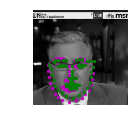

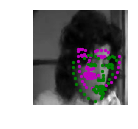

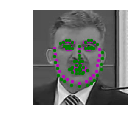

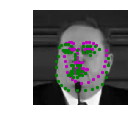

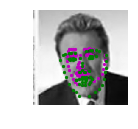

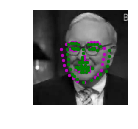

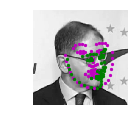

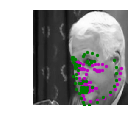

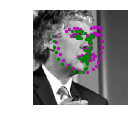

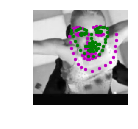

In [36]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


Once you've found a good model (or two), save your model so you can load it and use it later!

In [37]:
## TODO: change the name to something uniqe for each new model
model_dir = 'saved_models/'
model_name = 'keypoints_model_3_50epoch.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

In [29]:
batch_size = 50

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [7]:
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = torch.optim.Adam(net.parameters(), lr=.001)

In [ ]:
n_epochs = 5 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I decided to use the Mean Square error function between predicted and actual key points as an approximation. Predicting the points is a regression probelem and MSE is a good default choise. I was also considering using L1 and L1smooth loss as it gives less weight to outliers. In the end of the day I was happy with the results of the MSE loss. In fact the results were better than I expected given that there was only 3500 examples to train on. The results are very good for faces with straight into the camera orientation, however for some of the faces turned to the side, the network is having trouble predicting the exact location of the facial features. In general 10 random pictures shown  above are a good representation of the results.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I borrowed the idea for the arcitecture from the vgg19 network with a series of 3x3 convolutions followed by max pooling layers. Since I had only 3500 examples to train on I did not use multiple consequtive convolutions before the pooling layer, but rather just one convolution per one maxpooling. The idea was to gradually reduce the spatial dimensions from 224x224 to 112x112 to 56x56 to 28to28... ... to 4x4 at which point the average pooling was used. At the same time as the spatial dimensions were decresing I increased the number of features for each layer 2x for first few layers. There were 32 features at the first level, 64 features at 2nd level, 128 features for 3rd layer. Then I kept the number of features constant until the last convolutional layer where I increased the number of features to 256. The idea was to keep the number of features close to number of points predicted. The average pooling layer thus produced a 256 dimentional vector. After that I used two fully connected layers to recombine the features into final point prediction. I used relu activation as it seems to work well with convolutional networks. Also I used a dropout layers after each convolution to reduce overfitting. This was a special form of dropout that dropped entire features instead of individual weights within features. To improve the convergence speed and stability of the network I also used batch normalization. 


I also used two archtectures with same the same number of layers, but more features in some of the layers that can be found in models file as Net1 and Net2. These architectures used significantly more parameters for training, and the trainining error decreased by about 20%. However there was no appreciable difference in visual results or location of the points.


Final Note:

I was generally happy with the achieved results as they exceeded my expectations. So I settled on the first architecture that I used. Furthermore with only 3500 training examples I was concerned with overfitting and used conservative number of features in the network. As a result it seems that the network is underfitting a bit on faces that are at an angle. The good thing is that I do not see an observable difference between the test and training fit. However increasing the number of features did not really help with the unusual face angles. To improve results more data might need to be used.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: I trained the network both on my general purpose laptop and desktop which has GTX 1080 card on it. I started training with the default batch size of 10 and it would use almost all the memory of the laptop and hang the system when I tried to increse the batch size to 50. Selecting a small batch size can generally act as a form of additional regularization for training as the gradients produced are stochastic. However as I observed little overfitting there seemed to be little need to keep batch sizes small. My first results were produced by training the network for 5 epochs with batch size 10 and learning rate of .01. The results were satisfactory, but far from good. The network seemed to get the shape of the face right (oval for overall shape eyes above nose, and nose above mouth), but for many faces the produced shape would be to large or two small, and sometimes the predicted key points would be at the center of the photograph while the actual face would be to the side or in the corner.
I continued training on the laptop, keeping the learning rate at .01, increasing the batch_size and number of epochs to 50. The results were much better this time and the loss, thoug somewhat stochastically keep decresing slowly. I ran the process again for another 50 epochs. And the loss seem to stop decresing. Finally I decreased learning rate to .001 and ran for 500 epochs. Which produced the final results

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

[[-1.3300788  -0.58577776 -0.10602283]
 [-0.38795564 -0.2022259   0.17215218]
 [ 0.29211494  1.1642368   1.0248865 ]]
(3, 3)


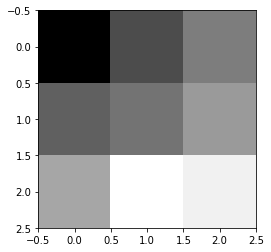

In [67]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

D:\pythonProjects\Vision\P1_Facial_Keypoints\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


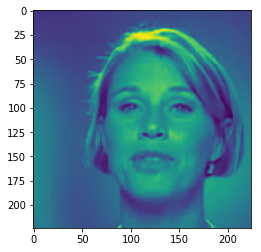

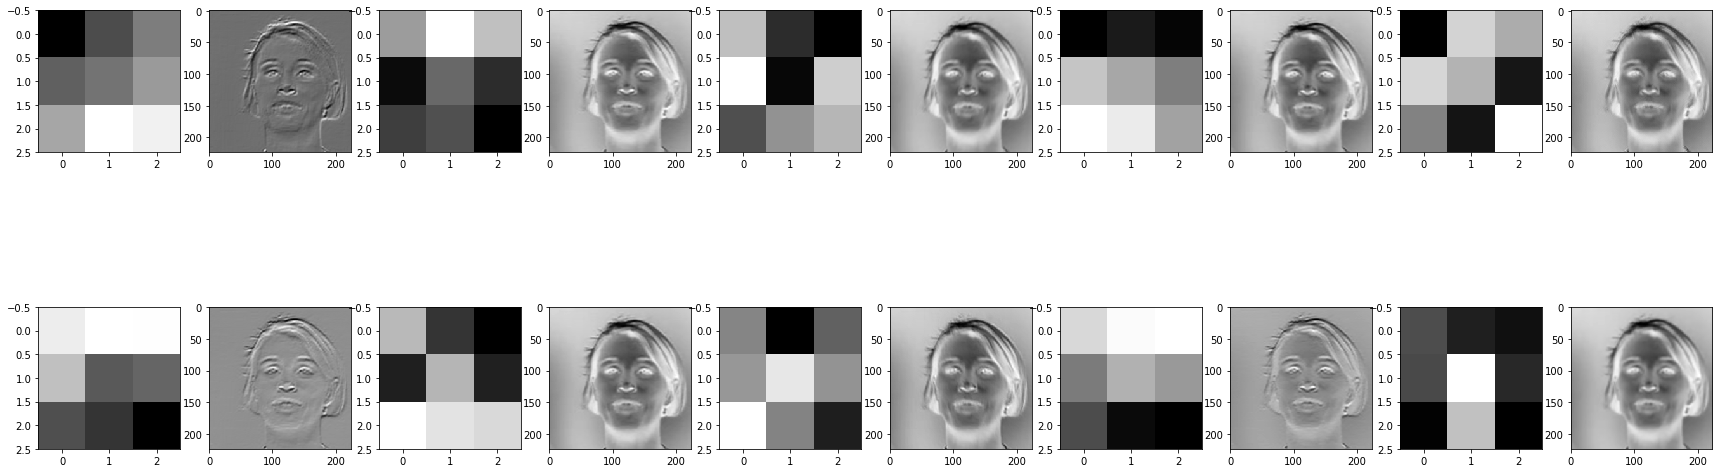

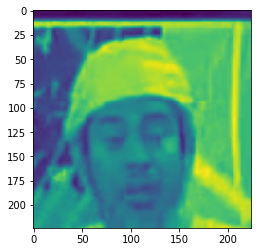

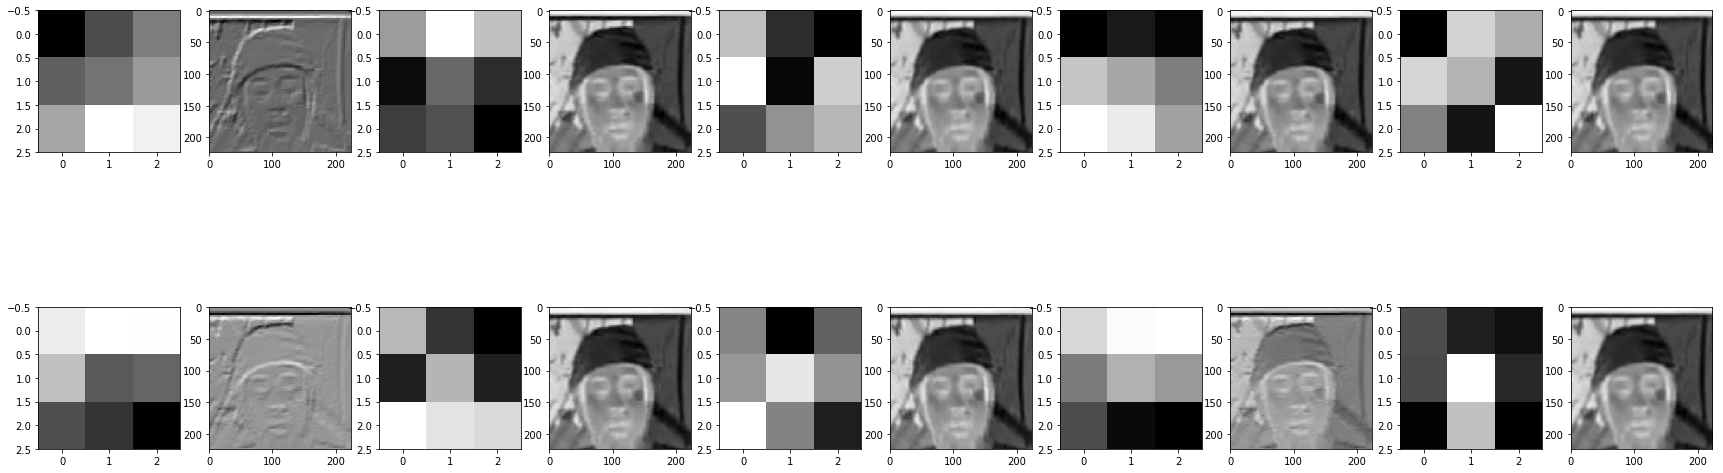

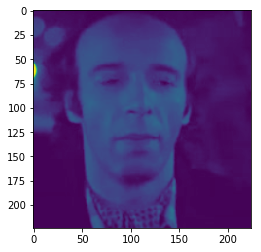

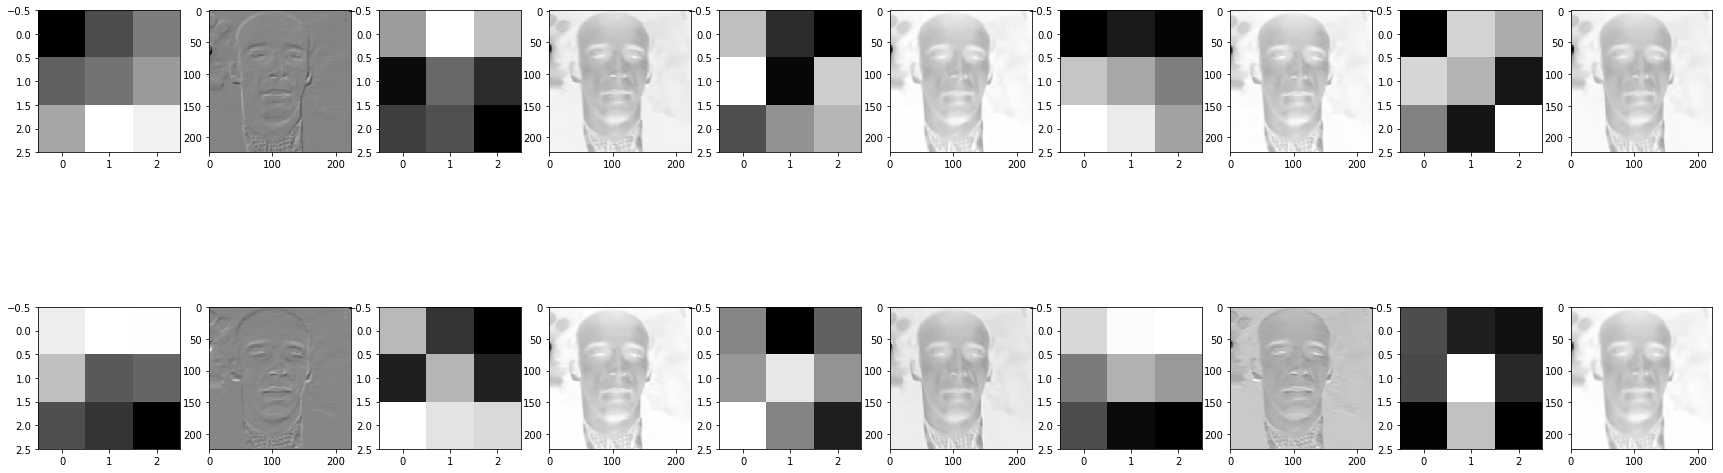

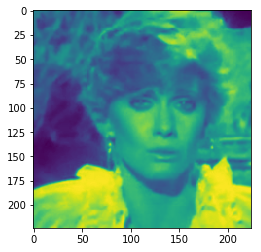

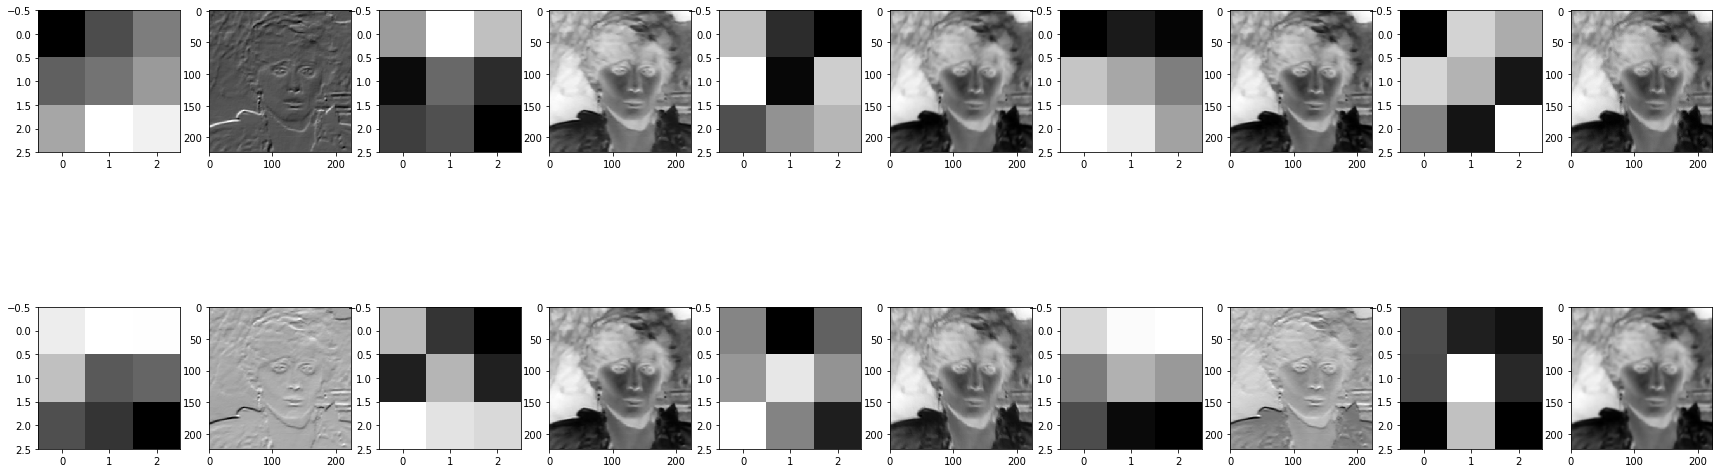

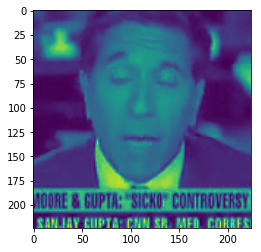

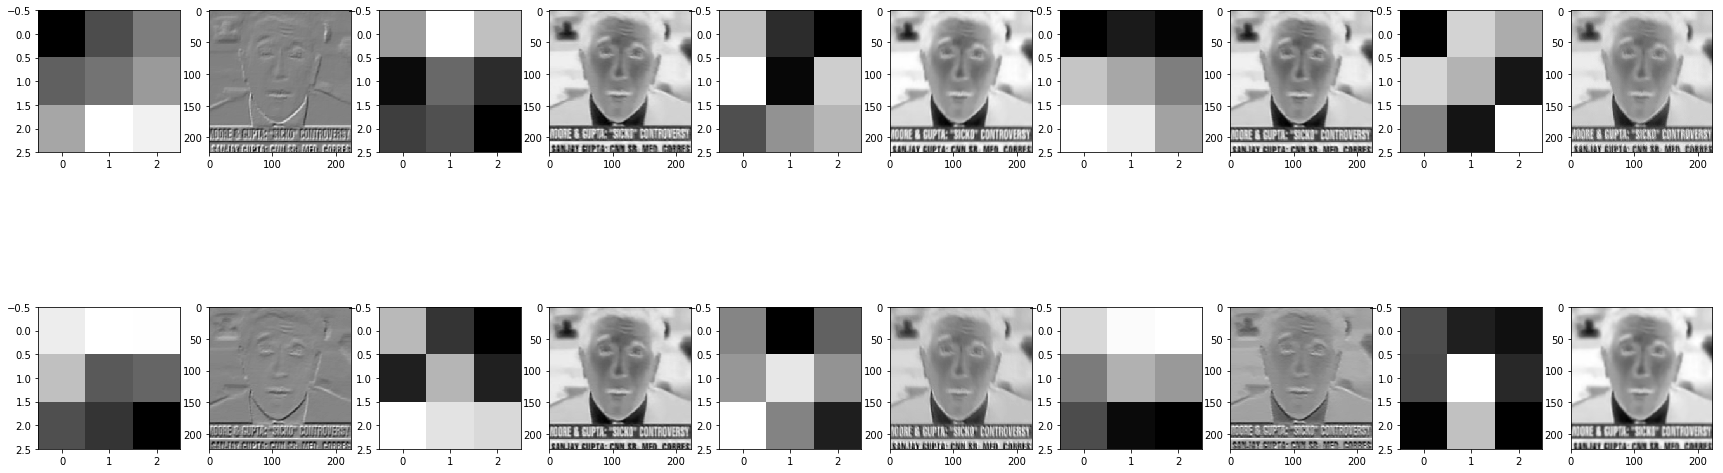

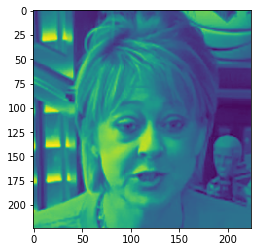

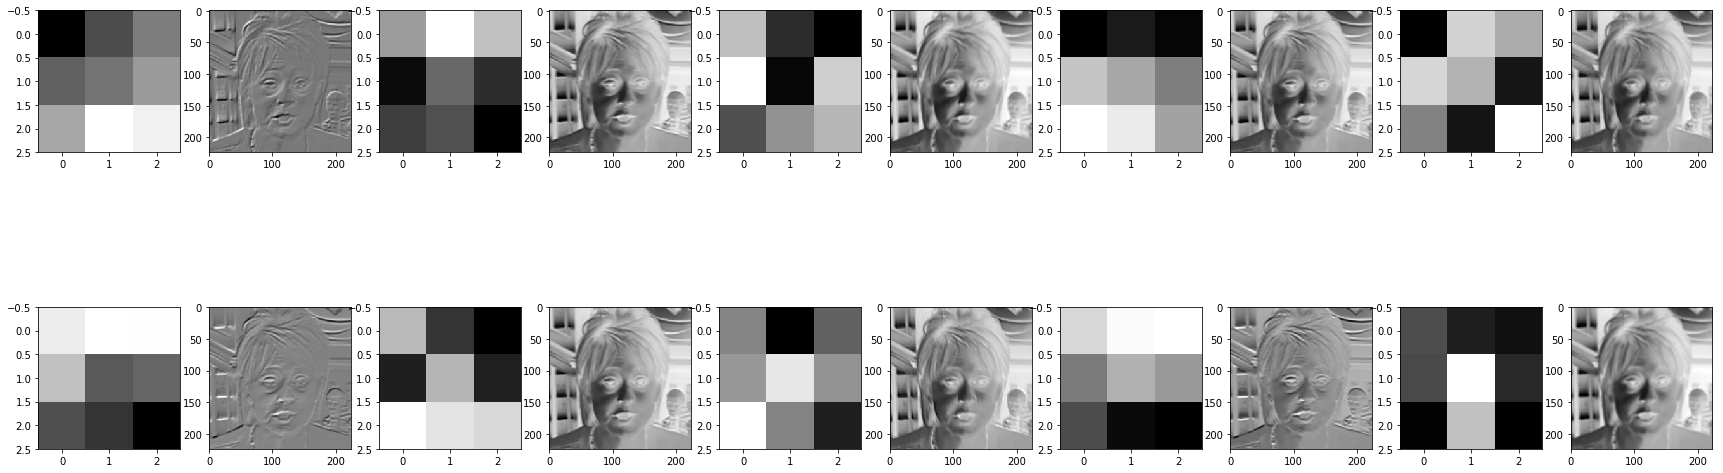

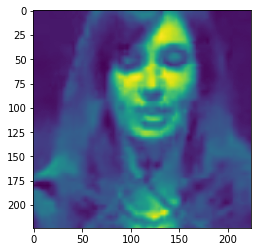

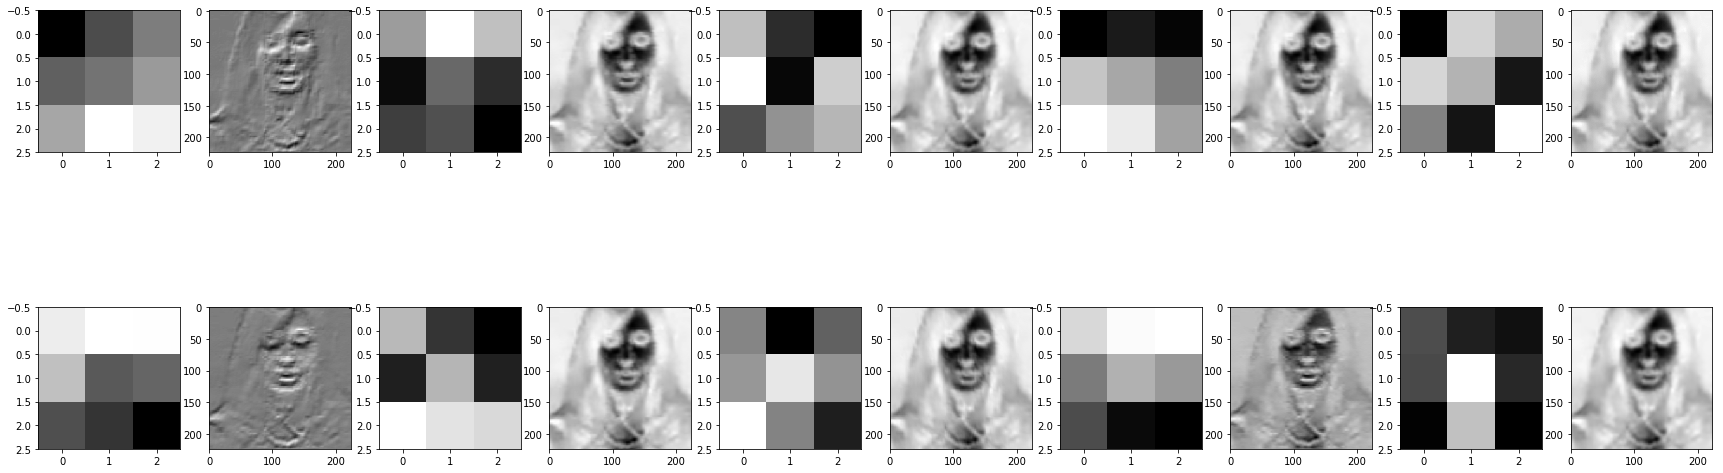

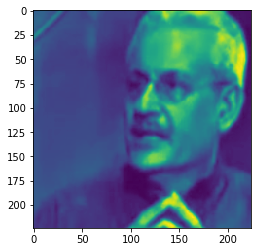

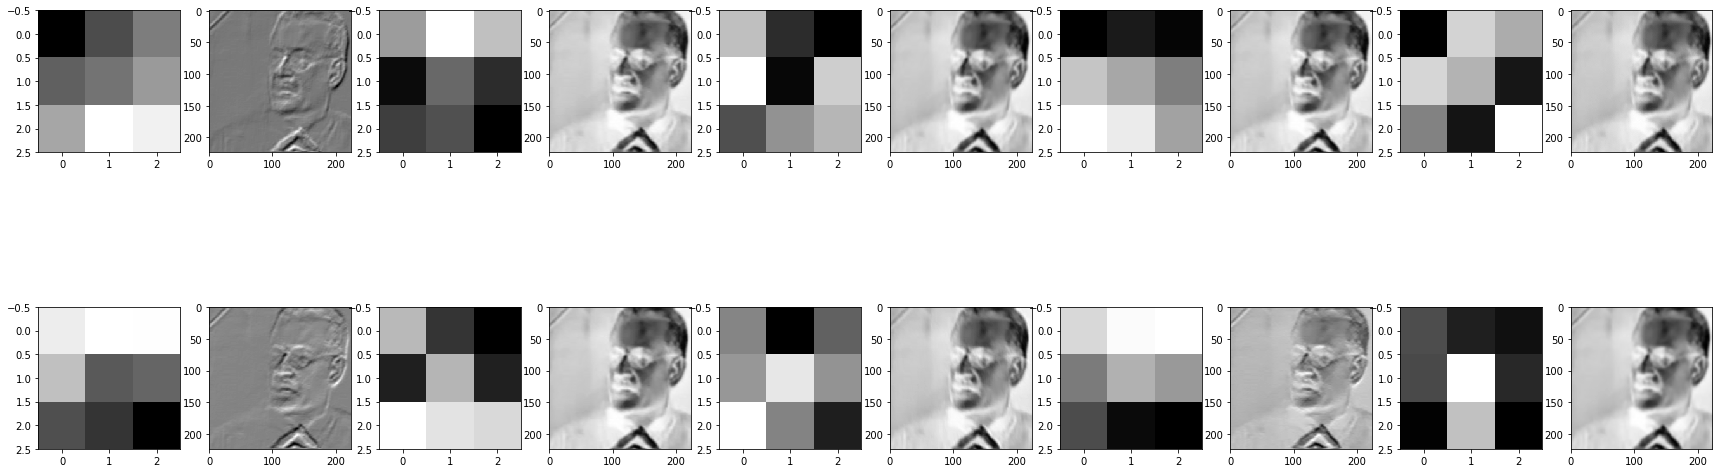

In [69]:
##TODO: load in and display any image from the transformed test dataset

## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
# obtain one batch of testing images
import cv2
for i, sample in enumerate(test_loader):
    img_number = 3;
    img = sample['image'][img_number]
    #print ((img.numpy()))
    
    #plt.imshow(img.numpy().reshape(224,224))
    #plt.show()
    img = img.numpy().reshape(224,224)
    plt.imshow(img)
    fig=plt.figure(figsize=(30, 10))
    columns = 5*2
    rows = 2
    for n in range(0, columns*rows):
        fig.add_subplot(rows, columns, n+1)
        if ((n%2)==0):
            plt.imshow(w[int(n/2)][0], cmap='gray')
        else:
            c = cv2.filter2D(img, -1, w[int((n-1)/2)][0])
            plt.imshow(c, cmap='gray')
    plt.show()
    
    
    if i == 7:
        break

[[ 1.042777    0.7621161   1.0782906 ]
 [ 0.322739    0.33814812  0.43550584]
 [-1.2963942  -1.2453234  -1.640142  ]]
(3, 3)


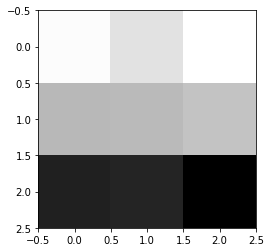

In [70]:
weights2 = net.conv2.weight.data

w = weights2.cpu().numpy()

filter_index = 0

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


D:\pythonProjects\Vision\P1_Facial_Keypoints\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


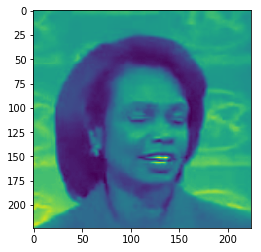

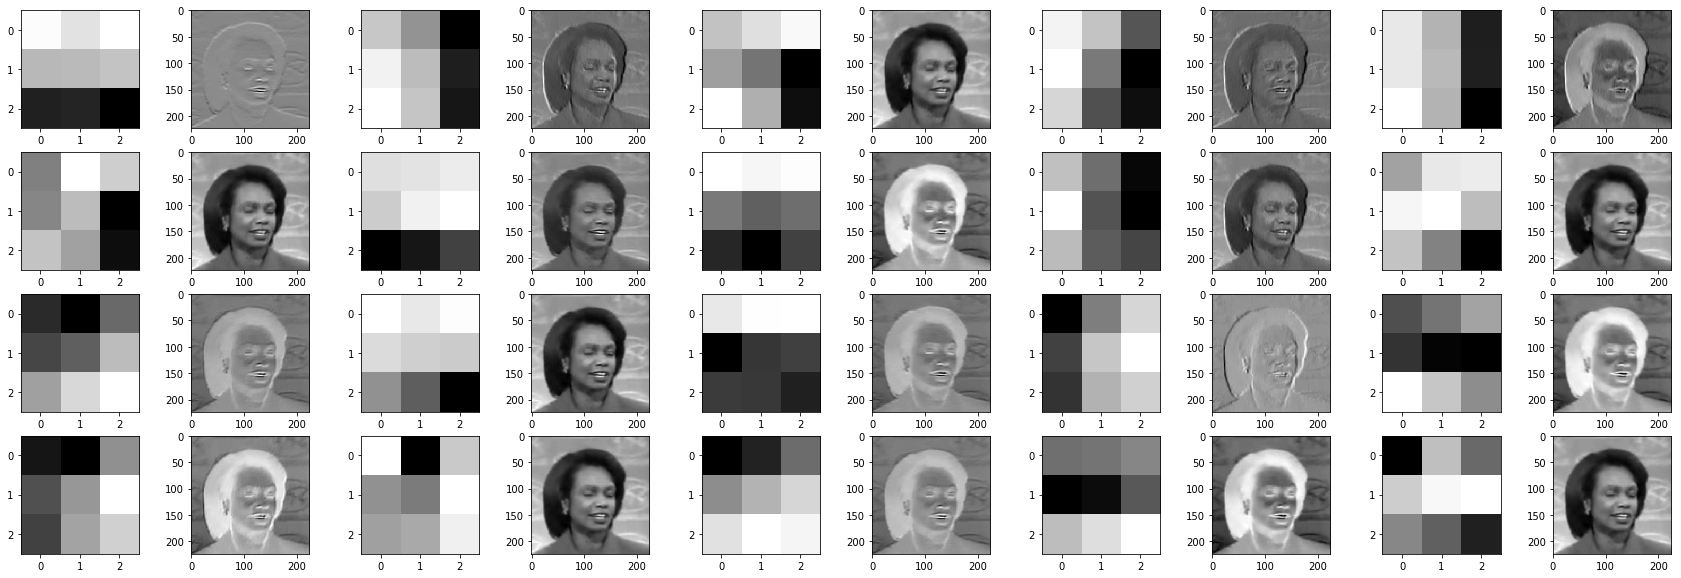

In [71]:
for i, sample in enumerate(test_loader):
    img_number = 3;
    img = sample['image'][img_number]
    #print ((img.numpy()))
    
    #plt.imshow(img.numpy().reshape(224,224))
    #plt.show()
    img = img.numpy().reshape(224,224)
    plt.imshow(img)
    fig=plt.figure(figsize=(30, 10))
    columns = 5*2
    rows = 2*2
    for n in range(0, columns*rows):
        fig.add_subplot(rows, columns, n+1)
        if ((n%2)==0):
            plt.imshow(w[int(n/2)][0], cmap='gray')
        else:
            c = cv2.filter2D(img, -1, w[int((n-1)/2)][0])
            plt.imshow(c, cmap='gray')
    plt.show()
    if i == 0:
        break

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: I find Filter 10 in first layer of the network the most interesting. It consistently produces white regions for the eyeballs, and around the eyes, for nostrils, eyebrow outlines, and around the mouth. The location of these regions can be a good indication for where the facial keypoints should be located.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!